Pour une lecture améliorée, ce notebook est idéalement lu avec une extension qui gère les niveaux des titres Markdown.  
Par exemple avec l'extension 'Table of Contents' du module 'Nbextensions' de Jupyter.

# Mise en place du notebook

## Import des modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress as reg_lin
from mesfonctions import scatter_plot

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


In [2]:
# pour développement only - cellule à supprimer du notebook final
import mesfonctions
from importlib import reload  
mesfonctions = reload(mesfonctions)
# from mesfonctions import xxx

## Gestion des paramètres d'affichage de Jupyter

In [3]:
# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200

# pour gérer l'affichage des arrays numpy
# 230 sur ma config bureau, 165 sur ma config portable
np.set_printoptions(linewidth=165)

# pour afficher les gros fichiers sur toute la largeur de l'écran
from IPython.core.display import HTML
HTML("<style>.container { width:95% }</style>")

## Fonctions à déplacer dans un fichier .py externe

In [4]:
def arrondi(x, chiffres=3, puissance10=None):
    """ Arrondit un nombre et gère les chiffres significatifs.
    Args :
    - x : nombre à arrondir.
    - chiffres : chiffres significatifs voulus.
    - puissance10 : x est exprimé en puissance 10 de cet argument.
    Returns :
    - le nombre arrondi.
    Examples:
    - arrondi(123.456, chiffres=2) retourne 120.
    - arrondi(0.0123456, chiffres=4) retourne 0.01234.
    - arrondi(123.456, puissance10=2) retourne le string 1.2e2.
    """
    y = round(x, -int(np.floor(np.log10(abs(x)))-chiffres+1))
    if y >= np.power(10, chiffres-1):
        y = int(y) # on supprime le .0 de tous les floats en Python
    if puissance10 is not None:
        y = "{0:.2f}".format(x/np.power(10, puissance10)) + "e" + str(puissance10)
    return y

In [5]:
arrondi(123456.7654321, chiffres=2)

120000

In [6]:
arrondi(123456.7654321, puissance10=3)

'123.46e3'

In [7]:
def display_scores(scores, chiffres=3, puissance10=None):
    """ Transforme la liste de scores retournés par cross_val_score() en valeurs simples à lire.
    Args :
    - scores : valeur fournie par cross_val_score().
    - chiffres : le nombre de chiffres significatifs affichés.
    Returns : 
    - tous les scores de la validation croisée, leur moyenne, leur écart-type
    """
    print("Scores: ", end='')
    for x in scores:
        print(arrondi(x, chiffres, puissance10), end=' ')
    print("\nMean:", arrondi(scores.mean(), chiffres, puissance10))
    print("Standard deviation:", arrondi(scores.std(ddof=1), chiffres, puissance10))

## Chargement du pickle du df nettoyé

In [8]:
df1 = pd.read_pickle('df1_après_nettoyage_Projet_Seattle.pkl')

# Première approche du problème : conservation d'un grand nombre de variables

## Feature engineering - première approche

### Surface au sol

Les pertes énergétiques des bâtiments avec une forte surface de contact avec l'extérieur seront plus importantes que celles des bâtiments avec une faible surface de contact.  
Sur la base des données disponibles, on ne pourra pas calculer cette surface.  
Toutefois on peut calculer la surface au sol des bâtiments. C'est un bon proxy de la surface de contact totale pour les bâtiments à peu d'étages.

Surface_au_sol(sf) = PropertyGFABuilding(s) / NumberofFloors 


In [9]:
df1['Surface_au_sol(sf)'] = df1['PropertyGFABuilding(s)'].copy() / df1['NumberofFloors'].copy()

In [10]:
df1['Surface_au_sol(sf)'].describe()

count    1.668000e+03
mean              inf
std               NaN
min      2.216970e+02
25%      1.235629e+04
50%      2.119500e+04
75%      3.438105e+04
max               inf
Name: Surface_au_sol(sf), dtype: float64

Il y a des valeurs np.inf lorsque NumberofFloors vaut 0 => on les transforme en NaN.

In [11]:
df1['Surface_au_sol(sf)'] = df1['Surface_au_sol(sf)'].apply(lambda x : np.NaN if x == np.inf else x)

In [12]:
df1['Surface_au_sol(sf)'].describe()

count    1.652000e+03
mean     3.177939e+04
std      4.708716e+04
min      2.216970e+02
25%      1.229850e+04
50%      2.102900e+04
75%      3.361888e+04
max      1.100000e+06
Name: Surface_au_sol(sf), dtype: float64

### Variables prédites

La demande de Douglas est de prédire les variables :  
    - 'SiteEnergyUse(kBtu)',  
    - 'TotalGHGEmissions',  
cependant, nous travaillerons plutôt sur la prévision de :  
    - 'SiteEUI(kBtu/sf)',  
    - 'GHGEmissionsIntensity',  
qui ont une relation plus "linéaire" avec les autres variables descriptives. 

## Variables retenues pour la modélisation

In [13]:
list(df1.columns)

['OSEBuildingID',
 'BuildingType',
 'PrimaryPropertyType',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'Surface_au_sol(sf)']

La demande de Douglas est de prédire les variables :  
    - 'SiteEnergyUse(kBtu)',  
    - 'TotalGHGEmissions',  
cependant, nous travaillerons plutôt sur la prévision de :  
    - 'SiteEUI(kBtu/sf)',  
    - 'GHGEmissionsIntensity',  
qui ont un lien plus "linéaire" avec les autres variables descriptives. 

In [14]:
liste_variables_pour_modelisation =[
    'BuildingType', 
    'PrimaryPropertyType', 
    'ZipCode',
    'CouncilDistrictCode', 
    'Neighborhood', 
    'Latitude', 
    'Longitude',
    'YearBuilt', 
    'NumberofBuildings', 
    'NumberofFloors', 
#     'PropertyGFATotal',    exclu car donnée extensive
#     'PropertyGFAParking',    exclu car donnée extensive
#     'PropertyGFABuilding(s)',  exclu car donnée extensive
    'LargestPropertyUseType',
#     'LargestPropertyUseTypeGFA',  exclu car donnée extensive
    'SecondLargestPropertyUseType', 
#     'SecondLargestPropertyUseTypeGFA',  exclu car donnée extensive
    'ThirdLargestPropertyUseType', 
#     'ThirdLargestPropertyUseTypeGFA',  exclu car donnée extensive
#     'ENERGYSTARScore', exclu sinon data leak
#     'SiteEUI(kBtu/sf)', variable à prédire
#     'SiteEUIWN(kBtu/sf)', exclu sinon data leak
#     'SourceEUI(kBtu/sf)', exclu sinon data leak
#     'SourceEUIWN(kBtu/sf)', exclu sinon data leak
#     'SiteEnergyUse(kBtu)', exclu sinon data leak
#     'SiteEnergyUseWN(kBtu)', exclu sinon data leak
#     'SteamUse(kBtu)', exclu sinon data leak
#     'Electricity(kWh)',exclu sinon data leak
#     'Electricity(kBtu)', exclu sinon data leak
#     'NaturalGas(therms)', exclu sinon data leak
#     'NaturalGas(kBtu)',exclu sinon data leak
#     'TotalGHGEmissions', exclu sinon data leak
#     'GHGEmissionsIntensity', variable à prédire
    'Surface_au_sol(sf)']

## Train test split 

POUR LE NOTEBOOK FINAL IL FAUDRA FAIRE LE SPLIT PLUS TOT (avant le nettoyage)  
IL FAUDRA FAIRE LE MEME NETTOYAGE SUR LES JEUX TRAIN ET TEST

POUR L'INSTANT ON NE TRAVAILLE QU'A LA PREDICTION DE SiteEUI(kBtu/sf)

In [15]:
# Suppression des lignes pour lesquelles la variable 'SiteEUI(kBtu/sf)'     ?? que se passe-t-il si je ne le fais pas ??
df1 = df1.dropna(subset=['SiteEUI(kBtu/sf)']).copy()

##### Variables à prédire :

In [16]:
y1_EUI = df1[['SiteEUI(kBtu/sf)']].copy()
# y1_GHGEI = df1['GHGEmissionsIntensity'].copy()     Pour l'instant on se contente de prédire y1_EUI.

##### Variables explicatives :

In [17]:
X1 = df1[liste_variables_pour_modelisation].copy()

##### Split :

In [18]:
X_train_EUI, X_test_EUI, y_train_EUI, y_test_EUI = train_test_split(X1, y1_EUI, test_size=0.2, random_state=0)

## Imputations

### Définition des variables quantitatives et qualitatives

In [19]:
list(X_train_EUI.columns)

['BuildingType',
 'PrimaryPropertyType',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'Surface_au_sol(sf)']

In [20]:
liste_variables_qualitatives = [
 'BuildingType',
 'PrimaryPropertyType',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
#  'Latitude',
#  'Longitude',
#  'YearBuilt',
#  'NumberofBuildings',
#  'NumberofFloors',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
#  'Surface_au_sol(sf)'
]

In [21]:
liste_variables_quantitatives = [
#  'BuildingType',
#  'PrimaryPropertyType',
#  'ZipCode',
#  'CouncilDistrictCode',
#  'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
#  'LargestPropertyUseType',
#  'SecondLargestPropertyUseType',
#  'ThirdLargestPropertyUseType',
 'Surface_au_sol(sf)'
]

In [22]:
X_train_EUI

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Surface_au_sol(sf)
3162,NonResidential,Large Office,98109.0,7,LAKE UNION,47.62037,-122.33627,2012,1.0,11,Office,Parking,Other,47856.636364
953,NonResidential,Worship Facility,98115.0,4,NORTHEAST,47.68752,-122.29852,2000,1.0,2,Worship Facility,NaN,NaN,15693.000000
2637,NonResidential,Hotel,98108.0,2,GREATER DUWAMISH,47.54774,-122.32091,1992,1.0,3,Hotel,NaN,NaN,7484.000000
29,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61558,-122.34186,1978,1.0,5,Hotel,NaN,NaN,10442.000000
1126,NonResidential,Small- and Mid-Sized Office,98108.0,2,GREATER DUWAMISH,47.55316,-122.32616,1982,1.0,2,Office,Non-Refrigerated Warehouse,NaN,20014.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,NonResidential,Retail Store,98134.0,2,GREATER DUWAMISH,47.56535,-122.34054,1953,1.0,1,Retail Store,Non-Refrigerated Warehouse,NaN,39900.000000
1192,NonResidential,Small- and Mid-Sized Office,98133.0,5,NORTHWEST,47.72004,-122.34418,1951,1.0,2,Office,Non-Refrigerated Warehouse,NaN,19907.500000
2120,NonResidential,Warehouse,98108.0,1,GREATER DUWAMISH,47.53160,-122.33300,1970,1.0,1,Non-Refrigerated Warehouse,NaN,NaN,44000.000000
580,NonResidential,University,98122.0,3,CENTRAL,47.60940,-122.31506,1916,1.0,2,College/University,Parking,NaN,30061.000000


In [23]:
X_train_EUI[liste_variables_quantitatives].describe()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,Surface_au_sol(sf)
count,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1.307000e+03
mean,47.616247,-122.332559,1962.246212,1.156818,4.200758,3.116310e+04
std,0.048964,0.024321,32.540533,3.187654,6.912526,4.779553e+04
min,47.510180,-122.411820,1900.000000,0.000000,0.000000,2.216970e+02
25%,47.584275,-122.342598,1930.000000,1.000000,1.000000,1.247250e+04
50%,47.612380,-122.332890,1966.000000,1.000000,2.000000,2.097500e+04
75%,47.650627,-122.321848,1989.000000,1.000000,4.000000,3.254500e+04
max,47.733870,-122.258640,2015.000000,111.000000,99.000000,1.100000e+06


In [24]:
X_train_EUI[liste_variables_quantitatives]

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,Surface_au_sol(sf)
3162,47.62037,-122.33627,2012,1.0,11,47856.636364
953,47.68752,-122.29852,2000,1.0,2,15693.000000
2637,47.54774,-122.32091,1992,1.0,3,7484.000000
29,47.61558,-122.34186,1978,1.0,5,10442.000000
1126,47.55316,-122.32616,1982,1.0,2,20014.500000
...,...,...,...,...,...,...
1045,47.56535,-122.34054,1953,1.0,1,39900.000000
1192,47.72004,-122.34418,1951,1.0,2,19907.500000
2120,47.53160,-122.33300,1970,1.0,1,44000.000000
580,47.60940,-122.31506,1916,1.0,2,30061.000000


### Imputation des variables quantitatives

In [25]:
imputer_quanti = SimpleImputer(strategy="median")

In [26]:
X_train_EUI[liste_variables_quantitatives] = imputer_quanti.fit_transform(X_train_EUI[liste_variables_quantitatives])

<ipython-input-26-f1c96264e1c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_EUI[liste_variables_quantitatives] = imputer_quanti.fit_transform(X_train_EUI[liste_variables_quantitatives])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [27]:
X_train_EUI[liste_variables_quantitatives].describe()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,Surface_au_sol(sf)
count,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1.320000e+03
mean,47.616247,-122.332559,1962.246212,1.156818,4.200758,3.106277e+04
std,0.048964,0.024321,32.540533,3.187654,6.912526,4.757006e+04
min,47.510180,-122.411820,1900.000000,0.000000,0.000000,2.216970e+02
25%,47.584275,-122.342598,1930.000000,1.000000,1.000000,1.265917e+04
50%,47.612380,-122.332890,1966.000000,1.000000,2.000000,2.097500e+04
75%,47.650627,-122.321848,1989.000000,1.000000,4.000000,3.236550e+04
max,47.733870,-122.258640,2015.000000,111.000000,99.000000,1.100000e+06


In [28]:
imputer_quanti.statistics_

array([ 4.7612380e+01, -1.2233289e+02,  1.9660000e+03,  1.0000000e+00,  2.0000000e+00,  2.0975000e+04])

### Imputation des variables qualitatives

In [29]:
X_train_EUI

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Surface_au_sol(sf)
3162,NonResidential,Large Office,98109.0,7,LAKE UNION,47.62037,-122.33627,2012.0,1.0,11.0,Office,Parking,Other,47856.636364
953,NonResidential,Worship Facility,98115.0,4,NORTHEAST,47.68752,-122.29852,2000.0,1.0,2.0,Worship Facility,NaN,NaN,15693.000000
2637,NonResidential,Hotel,98108.0,2,GREATER DUWAMISH,47.54774,-122.32091,1992.0,1.0,3.0,Hotel,NaN,NaN,7484.000000
29,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61558,-122.34186,1978.0,1.0,5.0,Hotel,NaN,NaN,10442.000000
1126,NonResidential,Small- and Mid-Sized Office,98108.0,2,GREATER DUWAMISH,47.55316,-122.32616,1982.0,1.0,2.0,Office,Non-Refrigerated Warehouse,NaN,20014.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,NonResidential,Retail Store,98134.0,2,GREATER DUWAMISH,47.56535,-122.34054,1953.0,1.0,1.0,Retail Store,Non-Refrigerated Warehouse,NaN,39900.000000
1192,NonResidential,Small- and Mid-Sized Office,98133.0,5,NORTHWEST,47.72004,-122.34418,1951.0,1.0,2.0,Office,Non-Refrigerated Warehouse,NaN,19907.500000
2120,NonResidential,Warehouse,98108.0,1,GREATER DUWAMISH,47.53160,-122.33300,1970.0,1.0,1.0,Non-Refrigerated Warehouse,NaN,NaN,44000.000000
580,NonResidential,University,98122.0,3,CENTRAL,47.60940,-122.31506,1916.0,1.0,2.0,College/University,Parking,NaN,30061.000000


In [30]:
X_train_EUI[liste_variables_qualitatives].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1320 entries, 3162 to 839
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BuildingType                  1320 non-null   object 
 1   PrimaryPropertyType           1320 non-null   object 
 2   ZipCode                       1307 non-null   float64
 3   CouncilDistrictCode           1320 non-null   int64  
 4   Neighborhood                  1320 non-null   object 
 5   LargestPropertyUseType        1316 non-null   object 
 6   SecondLargestPropertyUseType  686 non-null    object 
 7   ThirdLargestPropertyUseType   292 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 92.8+ KB


In [31]:
imputer_quali_ZC = SimpleImputer(strategy='constant', fill_value=None)     # fill_value will be 0 when imputing numerical data and “missing_value” for strings or object data types
imputer_quali_CDC = SimpleImputer(strategy='constant', fill_value=None) 
imputer_quali_autre = SimpleImputer(strategy='constant', fill_value=None) 

X_train_EUI[['ZipCode']] = imputer_quali_ZC.fit_transform(X_train_EUI[['ZipCode']])
X_train_EUI[['CouncilDistrictCode']] = imputer_quali_CDC.fit_transform(X_train_EUI[['CouncilDistrictCode']])
X_train_EUI[['BuildingType',
 'PrimaryPropertyType',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType']
] = imputer_quali_CDC.fit_transform(X_train_EUI[['BuildingType',
 'PrimaryPropertyType',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType']])

<ipython-input-31-7f652f4f67b0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_EUI[['ZipCode']] = imputer_quali_ZC.fit_transform(X_train_EUI[['ZipCode']])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-31-7f652f4f67b0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [32]:
X_train_EUI[X_train_EUI.isnull().any(axis=1)]

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Surface_au_sol(sf)


## One-hot encoding (variables qualitatives)

In [33]:
liste_variables_qualitatives

['BuildingType',
 'PrimaryPropertyType',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType']

In [34]:
# sklearn force à séparer l'encodage des variables strings et variables numériques
# encoder_num = OneHotEncoder(handle_unknown='ignore')
# encoder_str = OneHotEncoder(handle_unknown='ignore')
encoder = OneHotEncoder(handle_unknown='ignore')

# X_train_EUI_1hot_num = encoder_num.fit_transform(X_train_EUI[['ZipCode', 'CouncilDistrictCode']])
# X_train_EUI_1hot_str = encoder_str.fit_transform(X_train_EUI[['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType',  'SecondLargestPropertyUseType',  'ThirdLargestPropertyUseType']])
X_train_EUI_1hot = encoder.fit_transform(X_train_EUI[liste_variables_qualitatives])

# display(X_train_EUI_1hot_num)
# display(X_train_EUI_1hot_str)
display(X_train_EUI_1hot)

<1320x235 sparse matrix of type '<class 'numpy.float64'>'
	with 10560 stored elements in Compressed Sparse Row format>

In [35]:
encoder.categories_

[array(['Campus', 'NonResidential', 'Nonresidential COS', 'SPS-District K-12'], dtype=object),
 array(['Distribution Center', 'Hospital', 'Hotel', 'K-12 School', 'Laboratory', 'Large Office', 'Low-Rise Multifamily', 'Medical Office', 'Mixed Use Property',
        'Office', 'Other', 'Refrigerated Warehouse', 'Residence Hall', 'Restaurant', 'Retail Store', 'Self-Storage Facility', 'Senior Care Community',
        'Small- and Mid-Sized Office', 'Supermarket / Grocery Store', 'University', 'Warehouse', 'Worship Facility'], dtype=object),
 array([    0., 98011., 98013., 98020., 98033., 98053., 98070., 98101., 98102., 98103., 98104., 98105., 98106., 98107., 98108., 98109., 98111., 98112., 98113.,
        98114., 98115., 98116., 98117., 98118., 98119., 98121., 98122., 98124., 98125., 98126., 98133., 98134., 98136., 98144., 98146., 98154., 98155., 98164.,
        98165., 98168., 98177., 98178., 98181., 98185., 98195., 98199.]),
 array([1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array(['BALLARD', 'Ba

## Recalibrage (variables quantitatives)

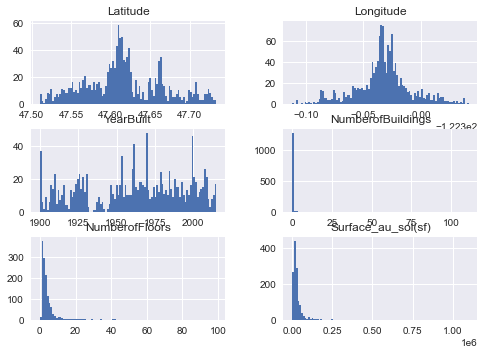

In [36]:
# Tracé des variables quantitatives avant recalibrage
plt.style.use('seaborn')
X_train_EUI[liste_variables_quantitatives].hist(bins=100)#, figsize=(22,15))
plt.show()

In [37]:
qt = QuantileTransformer(n_quantiles=1000, random_state=0, output_distribution='normal')
X_train_EUI_qt = qt.fit_transform(X_train_EUI[liste_variables_quantitatives])

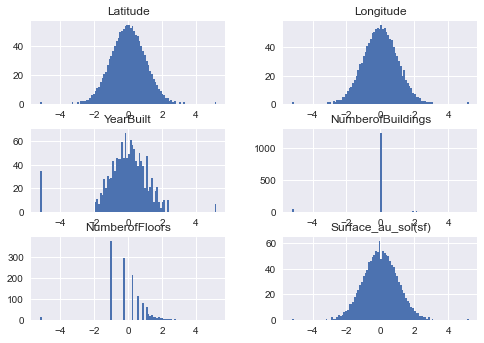

In [38]:
# Tracé des variables quantitatives après recalibrage
df_qt = pd.DataFrame(X_train_EUI_qt, columns=liste_variables_quantitatives)

plt.style.use('seaborn')
df_qt.hist(bins=100)
plt.show()

## Pipeline (imputation, one-hot encoding, recalibrage)

On combine les opérations décrites dans les chapitres précédents (imputation, one-hot encoding, recalibrage) en un workflow automatisé.

In [39]:
# On recrée les jeux de train/test avec split
X1 = df1[liste_variables_pour_modelisation].copy()
X_train_EUI, X_test_EUI, y_train_EUI, y_test_EUI = train_test_split(X1, y1_EUI, test_size=0.2, random_state=0)

### Pipeline variables quantitatives

In [40]:
pipeline_quanti = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', QuantileTransformer(n_quantiles=1000, random_state=0, output_distribution='normal')),
    ])

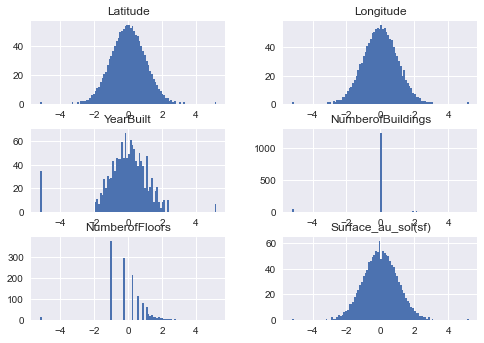

In [41]:
# test du pipeline
X_train_EUI_quanti = pipeline_quanti.fit_transform(X_train_EUI[liste_variables_quantitatives])

# Tracé des variables quantitatives après pipeline
df_quanti = pd.DataFrame(X_train_EUI_quanti, columns=liste_variables_quantitatives)
plt.style.use('seaborn')
df_quanti.hist(bins=100)
plt.show()

OK, on retrouve les mêmes histogrammes avec un pipeline.

### Pipeline variables qualitatives

L'imputer SimpleImputer de sklearn a un défaut de conception : lorsque le dataframe contient des données de type différents (string et numérique), les colonnes numériques sont imputées avec des strings.
Ce qui fait ensuiter bugger OneHotEncoder.
Il faut donc créer un imputeur maison et en faire un transformateur compatible avec un pipeline.

In [42]:
def Remplace_NA(df=None):
    """ Pour chaque variable, on remplace les valeurs null par une même valeur :  
      * 'ND' pour les strings,  
      * -1 pour les variables numériques.
    Args :
    - df : un dataframe.
    Returns : 
    - dff : le dataframe sans valeur null.
    """
    dff = df.copy()
    for var in liste_variables_qualitatives:
        if dff[var].dtype == 'object' :
            dff[var] = dff[var].fillna(value='ND', inplace=False)
        else :
            dff[var] = dff[var].fillna(value=-1, inplace=False)
    return dff
            
MonImputeur = FunctionTransformer(Remplace_NA)

In [43]:
pipeline_quali = Pipeline([
        ('imputer', MonImputeur),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

# pipeline_quali.fit_transform(X_train_EUI[liste_variables_qualitatives])

### Union des pipelines (ColumnTransformer)

In [44]:
full_pipeline = ColumnTransformer([
        ("quanti", pipeline_quanti, liste_variables_quantitatives),
        ("quali", pipeline_quali, liste_variables_qualitatives)
    ])

X_train_EUI_prepared = full_pipeline.fit_transform(X_train_EUI)

X_train_EUI_prepared

<1320x241 sparse matrix of type '<class 'numpy.float64'>'
	with 18466 stored elements in Compressed Sparse Row format>

In [45]:
# visualisation du pipeline
set_config(display='diagram')
full_pipeline

ColumnTransformer(transformers=[('quanti',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler',
                                                  QuantileTransformer(output_distribution='normal',
                                                                      random_state=0))]),
                                 ['Latitude', 'Longitude', 'YearBuilt',
                                  'NumberofBuildings', 'NumberofFloors',
                                  'Surface_au_sol(sf)']),
                                ('quali',
                                 Pipeline(steps=[('imputer',
                                                  FunctionTransformer(func=<function Remplace_NA at 0x000000000DDE5C10>)),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['BuildingType', 'PrimaryPropertyType',
                                  'ZipCode', 'CouncilDistrictCode',
                                  'Neighborhood', 'LargestPropertyUseType',
                                  'SecondLargestPropertyUseType',
                                  'ThirdLargestPropertyUseType'])])

## Régressions linéaires

### Régression linéaire simple

In [46]:
lin_reg = LinearRegression()

# Entrainement
lin_reg.fit(X_train_EUI_prepared, y_train_EUI)

LinearRegression()

In [47]:
# Test de quelques valeurs prédites
some_data = X_train_EUI.iloc[:100]
some_labels = y_train_EUI.iloc[:100].copy()
some_data_prepared = full_pipeline.transform(some_data)
some_data_predicted = lin_reg.predict(some_data_prepared)

some_labels['Prédictions'] = some_data_predicted
some_labels.head(10)

,SiteEUI(kBtu/sf),Prédictions
3162,42.799999,59.230377
953,37.599998,28.567644
2637,55.400002,74.624596
29,92.900002,75.240507
1126,36.799999,27.209902
773,45.500000,78.520747
305,89.300003,193.994349
2928,35.000000,75.721566
579,104.099998,92.325513
713,40.200001,21.662289


#### Metrics

##### RMSE :

In [48]:
EUI_predictions = lin_reg.predict(X_train_EUI_prepared)
lin_mse = mean_squared_error(y_train_EUI, EUI_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

44.14250276888454

##### MAE :

In [49]:
lin_mae = mean_absolute_error(y_train_EUI, EUI_predictions)
lin_mae

28.421632962349197

##### R² :

In [50]:
#R² par la méthode score() du transformateur
lin_reg.score(X_train_EUI_prepared, y_train_EUI)

0.6190790834015425

In [51]:
#R² par la fonction r2_score de metrics
r2_score(y_train_EUI, EUI_predictions)

0.6190790834015425

#### Scatter plot

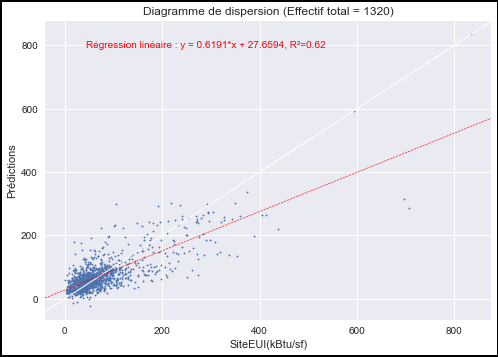

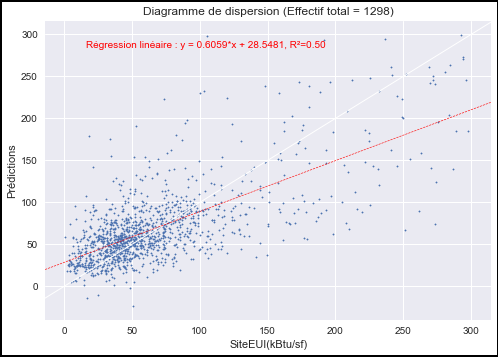

In [52]:
ser_predictions = pd.Series(np.squeeze(EUI_predictions), name='Prédictions')
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, ligne_diagonale=True)
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=300, max_y=300, ligne_diagonale=True)

#### Analyse des paramètres du modèle

In [53]:
lin_reg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [54]:
lin_reg.intercept_

array([106.38667152])

In [55]:
print("lin_reg.coef_ shape :", lin_reg.coef_.shape)
coefs = lin_reg.coef_

lin_reg.coef_ shape : (1, 241)


In [56]:
modalites_var_quali = full_pipeline.named_transformers_['quali'].named_steps['encoder'].get_feature_names(input_features=liste_variables_qualitatives)
modalites_var_quali

array(['BuildingType_Campus', 'BuildingType_NonResidential', 'BuildingType_Nonresidential COS', 'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_K-12 School',
       'PrimaryPropertyType_Laboratory', 'PrimaryPropertyType_Large Office', 'PrimaryPropertyType_Low-Rise Multifamily', 'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other', 'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall', 'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail Store', 'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community', 'PrimaryPropertyType_Small- and Mid-Sized Office', 'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse', 'PrimaryPropertyType_Wo

In [57]:
noms_des_coefs = np.concatenate([liste_variables_quantitatives, modalites_var_quali])

In [58]:
# inspiré de https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#interpreting-coefficients-scale-matters
df_coefs = pd.DataFrame(coefs.T, columns=['Coefficients'], index=noms_des_coefs)
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', None, 'display.max_columns', 100, 'display.precision', 1) :
    display(df_coefs.sort_values(by='Coefficients', ascending=False))

,Coefficients
ZipCode_98013.0,393.9
ZipCode_98185.0,367.6
LargestPropertyUseType_Data Center,367.6
PrimaryPropertyType_Laboratory,184.2
PrimaryPropertyType_Supermarket / Grocery Store,154.2
LargestPropertyUseType_Restaurant,152.6
SecondLargestPropertyUseType_Data Center,131.2
LargestPropertyUseType_Other/Specialty Hospital,105.8
ThirdLargestPropertyUseType_Strip Mall,97.5
ThirdLargestPropertyUseType_Other - Recreation,95.9


In [59]:
df_coefs.loc[liste_variables_quantitatives]

,Coefficients
Latitude,5.504705
Longitude,6.462588
YearBuilt,-1.182663
NumberofBuildings,-1.682082
NumberofFloors,-0.685633
Surface_au_sol(sf),1.256171


#### Cross validation

In [60]:
lin_scores = cross_val_score(lin_reg, X_train_EUI_prepared, y_train_EUI,
                             scoring="neg_root_mean_squared_error", cv=10)
display_scores(-lin_scores)

Scores: 52.6 60.8 57.3 72.2 47.0 94.2 53.8 60.5 53.3 54.3 
Mean: 60.6
Standard deviation: 13.6


In [61]:
lin_scores = cross_val_score(lin_reg, X_train_EUI_prepared, y_train_EUI,
                             scoring="r2", cv=10)
display_scores(lin_scores)

Scores: 0.505 -0.195 0.0253 0.295 0.287 0.142 0.313 0.26 0.113 0.49 
Mean: 0.223
Standard deviation: 0.211


On passe de RMSE=44 (validation sur le jeu d'entraînement) à 61 (validation croisée) en moyenne.  
On passe de MAE=28 (validation sur le jeu d'entraînement) à 22 (validation croisée) en moyenne.  
On passe de R²=0.62 (validation sur le jeu d'entraînement) à 0.22 (validation croisée) en moyenne.  
La généralisation du modèle est très mauvaise (surajustement).

### Régression linéaire avec transformation de y_train

#### Transformation = QuantileTransformer

In [62]:
transformer = QuantileTransformer(output_distribution='normal')
regressor = LinearRegression()
regr_ttr = TransformedTargetRegressor(regressor=regressor, transformer=transformer)

# Entrainement
regr_ttr.fit(X_train_EUI_prepared, y_train_EUI)

TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [63]:
# Test de quelques valeurs prédites
some_data_predicted_ttr = regr_ttr.predict(some_data_prepared)

some_labels['Prédictions_ttr'] = some_data_predicted_ttr
some_labels.head(20)

,SiteEUI(kBtu/sf),Prédictions,Prédictions_ttr
3162,42.799999,59.230377,53.377343
953,37.599998,28.567644,32.000000
2637,55.400002,74.624596,73.542116
29,92.900002,75.240507,70.252179
1126,36.799999,27.209902,37.327752
773,45.500000,78.520747,56.000000
305,89.300003,193.994349,172.881348
2928,35.000000,75.721566,46.405772
579,104.099998,92.325513,85.926674
713,40.200001,21.662289,32.428055


##### RMSE :

In [64]:
EUI_predictions = regr_ttr.predict(X_train_EUI_prepared)
lin_mse = mean_squared_error(y_train_EUI, EUI_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

46.28090815019097

##### R²

In [65]:
#R² par la méthode score() du transformateur
regr_ttr.score(X_train_EUI_prepared, y_train_EUI)

0.5812790800110295

In [66]:
#R² par la fonction r2_score de metrics
r2_score(y_train_EUI, EUI_predictions)

0.5812790800110295

##### Scatter plot :

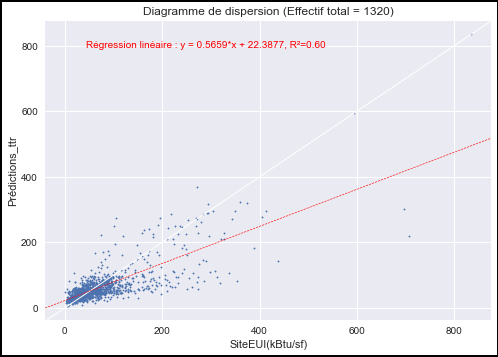

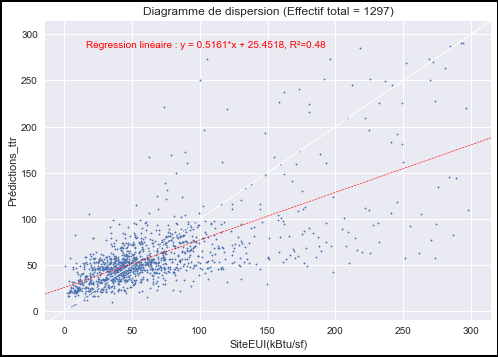

In [67]:
ser_predictions = pd.Series(np.squeeze(EUI_predictions), name='Prédictions_ttr')
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, ligne_diagonale=True)
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=300, max_y=300, ligne_diagonale=True)

Il n'y a pas eu d'amélioration par l'ajout d'une transformation de y_train.

#### Transformation = fonction log

In [68]:
regressor = LinearRegression()
regr_ttr2 = TransformedTargetRegressor(regressor=regressor, func=np.log, inverse_func=np.exp)

# Entrainement
regr_ttr2.fit(X_train_EUI_prepared, y_train_EUI)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())

In [69]:
# Test de quelques valeurs prédites
some_data_predicted_ttr = regr_ttr2.predict(some_data_prepared)

some_labels['Prédictions_ttr2'] = some_data_predicted_ttr
some_labels.head(20)

,SiteEUI(kBtu/sf),Prédictions,Prédictions_ttr,Prédictions_ttr2
3162,42.799999,59.230377,53.377343,56.714187
953,37.599998,28.567644,32.000000,31.113047
2637,55.400002,74.624596,73.542116,78.030090
29,92.900002,75.240507,70.252179,70.563247
1126,36.799999,27.209902,37.327752,35.053509
773,45.500000,78.520747,56.000000,56.132265
305,89.300003,193.994349,172.881348,151.302783
2928,35.000000,75.721566,46.405772,49.095230
579,104.099998,92.325513,85.926674,87.038591
713,40.200001,21.662289,32.428055,30.479381


##### RMSE :

In [70]:
EUI_predictions = regr_ttr2.predict(X_train_EUI_prepared)
lin_mse = mean_squared_error(y_train_EUI, EUI_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

45.66865325114479

##### R²

In [71]:
#R² par la méthode score() du transformateur
regr_ttr2.score(X_train_EUI_prepared, y_train_EUI)

0.5922844043372848

In [72]:
#R² par la fonction r2_score de metrics
r2_score(y_train_EUI, EUI_predictions)

0.5922844043372848

##### Scatter plot :

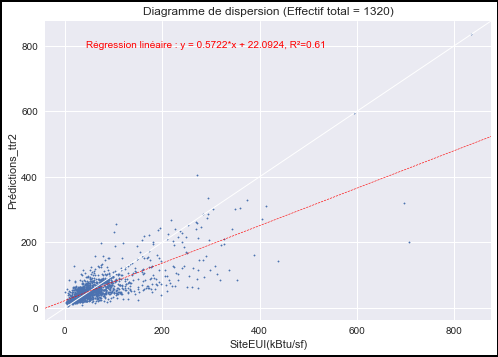

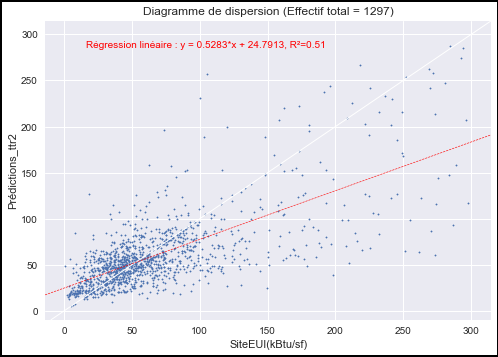

In [73]:
ser_predictions = pd.Series(np.squeeze(EUI_predictions), name='Prédictions_ttr2')
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, ligne_diagonale=True)
scatter_plot(ser_x=y_train_EUI.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=300, max_y=300, ligne_diagonale=True)

Il n'y a pas eu d'amélioration par l'ajout d'une transformation de y_train.

## Arbres de décision

In [74]:
tree_reg = DecisionTreeRegressor(random_state=0)
tree_reg.fit(X_train_EUI_prepared, y_train_EUI)

DecisionTreeRegressor(random_state=0)

In [75]:
EUI_predictions = tree_reg.predict(X_train_EUI_prepared)
tree_mse = mean_squared_error(y_train_EUI, EUI_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse  

0.0

In [76]:
print("R² =", r2_score(y_train_EUI, EUI_predictions))

R² = 1.0


RMSE = 0 et R² = 1 car car test sur jeu d'entrainement d'un arbre totalement ajusté

##### RMSE / validation croisée

In [77]:
scores = cross_val_score(tree_reg, X_train_EUI_prepared, y_train_EUI, 
                         scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores)

Scores: 64.1 84.4 69.2 84.7 52.0 107 77.5 76.6 51.9 66.0 
Mean: 73.3
Standard deviation: 16.6


##### R² / validation croisée

In [78]:
scores = cross_val_score(tree_reg, X_train_EUI_prepared, y_train_EUI, 
                         scoring="r2", cv=10)
display_scores(scores)

Scores: 0.265 -1.3 -0.42 0.0296 0.128 -0.105 -0.423 -0.186 0.16 0.247 
Mean: -0.161
Standard deviation: 0.474


On passe de RMSE=0 (validation sur le jeu d'entraînement) à 74 (validation croisée) en moyenne.  
On passe de R²=1 (validation sur le jeu d'entraînement) à 0.18 (validation croisée) en moyenne.  
La généralisation du modèle est très mauvaise (surajustement).

## Forêts aléatoires

In [79]:
forest_reg = RandomForestRegressor(n_estimators=20, max_features=80, random_state=0)
forest_reg.fit(X_train_EUI_prepared, y_train_EUI.iloc[:,0])

RandomForestRegressor(max_features=80, n_estimators=20, random_state=0)

In [80]:
forest_predictions = forest_reg.predict(X_train_EUI_prepared)
forest_mse = mean_squared_error(y_train_EUI, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse     # attention : test sur jeu d'entrainement

22.967151568519512

In [78]:
forest_scores = cross_val_score(forest_reg, X_train_EUI_prepared, y_train_EUI.iloc[:,0],
                                scoring="neg_root_mean_squared_error", cv=10)
display_scores(-forest_scores)

Scores: [46.35931336 52.79116864 48.57495715 68.5073984  43.20171605 92.77041426 53.82424918 60.07358346 45.5122609  54.5836096 ]
Mean: 56.619867100334204
Standard deviation: 14.000534295444321


RMSE moyen = 59. C'est un peu mieux que la rég. linéaire (RMSE moyen = 60).

### GridSearchCV

##### Scoring = -RMSE :

In [79]:
param_grid = [
#     {'n_estimators': [10], 'max_features': [10], 'random_state': [0]},
    {'n_estimators': [20, 40, 80], 'max_features': [40, 80, 160], 'random_state': [0]},
#     {'n_estimators': [5, 20], 'max_features': [20, 40, 80], 'random_state': [0], 'bootstrap': [False]},
            ]
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_root_mean_squared_error', return_train_score=True)
grid_search.fit(X_train_EUI_prepared, y_train_EUI.iloc[:,0])

GridSearchCV(cv=10,
             estimator=RandomForestRegressor(max_features=80, n_estimators=20,
                                             random_state=0),
             param_grid=[{'max_features': [40, 80, 160],
                          'n_estimators': [20, 40, 80], 'random_state': [0]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [80]:
grid_search.best_params_

{'max_features': 40, 'n_estimators': 80, 'random_state': 0}

In [81]:
grid_search.best_estimator_

RandomForestRegressor(max_features=40, n_estimators=80, random_state=0)

In [82]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("RMSE =", -mean_score, params)

RMSE = 57.239659770257525 {'max_features': 40, 'n_estimators': 20, 'random_state': 0}
RMSE = 56.435695757676925 {'max_features': 40, 'n_estimators': 40, 'random_state': 0}
RMSE = 56.03122562381208 {'max_features': 40, 'n_estimators': 80, 'random_state': 0}
RMSE = 56.619867100334204 {'max_features': 80, 'n_estimators': 20, 'random_state': 0}
RMSE = 56.20627075849389 {'max_features': 80, 'n_estimators': 40, 'random_state': 0}
RMSE = 56.20917287264568 {'max_features': 80, 'n_estimators': 80, 'random_state': 0}
RMSE = 57.85605039544852 {'max_features': 160, 'n_estimators': 20, 'random_state': 0}
RMSE = 57.71040841330482 {'max_features': 160, 'n_estimators': 40, 'random_state': 0}
RMSE = 57.18921725191892 {'max_features': 160, 'n_estimators': 80, 'random_state': 0}


In [83]:
with pd.option_context('display.max_rows', 400, 'display.max_colwidth', 1000):
    display(pd.DataFrame(grid_search.cv_results_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.303752,0.031814,0.006097,0.002021,40,20,0,"{'max_features': 40, 'n_estimators': 20, 'random_state': 0}",-49.370059,-51.708415,-46.579767,-69.741468,-44.507281,-94.253757,-50.681456,-61.246761,-47.527919,-56.779715,-57.239660,14.311558,7,-24.206277,-24.419396,-25.104111,-24.092854,-25.716778,-23.230413,-24.661270,-23.665686,-22.470940,-23.131172,-24.069890,0.926218
1,0.581592,0.047578,0.009796,0.003248,40,40,0,"{'max_features': 40, 'n_estimators': 40, 'random_state': 0}",-47.008299,-52.658198,-46.642896,-69.261019,-42.508061,-92.912807,-50.857122,-60.912684,-47.050013,-54.545860,-56.435696,14.251029,4,-22.311133,-22.536844,-22.855478,-21.940012,-23.738228,-21.814727,-23.413570,-22.654748,-22.282342,-22.447288,-22.599437,0.573552
2,1.225483,0.057771,0.016717,0.007028,40,80,0,"{'max_features': 40, 'n_estimators': 80, 'random_state': 0}",-46.672075,-53.958788,-45.822227,-68.888252,-41.563324,-91.823612,-50.511403,-59.943893,-47.224905,-53.903778,-56.031226,14.070129,1,-21.758405,-21.724658,-22.123593,-21.052326,-22.385553,-20.245791,-22.244719,-21.891503,-21.905236,-21.578299,-21.691008,0.598093
3,0.425218,0.029379,0.004498,0.001026,80,20,0,"{'max_features': 80, 'n_estimators': 20, 'random_state': 0}",-46.359313,-52.791169,-48.574957,-68.507398,-43.201716,-92.770414,-53.824249,-60.073583,-45.512261,-54.583610,-56.619867,14.000534,5,-23.951631,-24.109280,-26.012742,-23.458490,-25.816055,-23.319921,-24.632466,-23.813969,-22.933450,-23.659260,-24.170727,0.975499
4,0.731955,0.065525,0.010352,0.006331,80,40,0,"{'max_features': 80, 'n_estimators': 40, 'random_state': 0}",-45.329555,-54.822802,-46.905958,-68.140557,-41.770046,-92.518498,-52.551561,-60.282344,-45.918010,-53.823376,-56.206271,14.204296,2,-22.362234,-22.337780,-23.398181,-22.096830,-23.749700,-21.711125,-23.417666,-23.045871,-22.884919,-22.958518,-22.796282,0.618005
5,2.077902,0.465442,0.018406,0.003523,80,80,0,"{'max_features': 80, 'n_estimators': 80, 'random_state': 0}",-46.027596,-54.081524,-47.009963,-67.185690,-41.975519,-92.493493,-53.621658,-60.706059,-45.710011,-53.280216,-56.209173,14.064772,3,-21.925083,-21.794090,-22.477034,-21.250894,-22.725835,-20.174781,-22.270122,-22.065529,-22.292584,-21.930826,-21.890678,0.688704
6,0.684541,0.057798,0.003498,0.002906,160,20,0,"{'max_features': 160, 'n_estimators': 20, 'random_state': 0}",-46.671417,-57.453660,-51.248258,-70.121762,-44.353472,-91.483671,-55.399055,-63.200329,-45.999857,-52.629023,-57.856050,13.546196,9,-24.545915,-24.695503,-26.103815,-23.794392,-25.699977,-23.192714,-24.873141,-23.924810,-23.682448,-23.626362,-24.413908,0.899276
7,1.149458,0.146133,0.003125,0.006251,160,40,0,"{'max_features': 160, 'n_estimators': 40, 'random_state': 0}",-47.304062,-57.558361,-50.192390,-68.740656,-43.366075,-91.967099,-55.136899,-63.117122,-45.787081,-53.934339,-57.710408,13.631078,8,-22.541598,-22.772351,-23.941286,-22.276915,-24.145729,-22.109760,-23.811613,-22.988914,-23.004042,-23.005767,-23.059797,0.663263
8,2.191561,0.105640,0.009148,0.007643,160,80,0,"{'max_features': 160, 'n_estimators': 80, 'random_state': 0}",-46.786696,-55.712123,-48.687801,-68.252002,-42.587755,-91.618014,-56.208029,-62.202890,-45.259591,-54.577271,-57.189217,13.707064,6,-22.005714,-22.115635,-22.827102,-21.571249,-22.960586,-20.481822,-22.532114,-22.189414,-22.450442,-22.311465,-22.144554,0.672227



##### Scoring = R² :

In [84]:
param_grid = [
#     {'n_estimators': [10], 'max_features': [10], 'random_state': [0]},
    {'n_estimators': [20, 40, 80], 'max_features': [40, 80, 160], 'random_state': [0]},
#     {'n_estimators': [5, 20], 'max_features': [20, 40, 80], 'random_state': [0], 'bootstrap': [False]},
            ]
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='r2', return_train_score=True)
grid_search.fit(X_train_EUI_prepared, y_train_EUI.iloc[:,0])

GridSearchCV(cv=10,
             estimator=RandomForestRegressor(max_features=80, n_estimators=20,
                                             random_state=0),
             param_grid=[{'max_features': [40, 80, 160],
                          'n_estimators': [20, 40, 80], 'random_state': [0]}],
             return_train_score=True, scoring='r2')

In [85]:
grid_search.best_params_

{'max_features': 40, 'n_estimators': 80, 'random_state': 0}

In [86]:
grid_search.best_estimator_

RandomForestRegressor(max_features=40, n_estimators=80, random_state=0)

In [87]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", -mean_score, params)

R² = -0.3267041569941818 {'max_features': 40, 'n_estimators': 20, 'random_state': 0}
R² = -0.34246350938242387 {'max_features': 40, 'n_estimators': 40, 'random_state': 0}
R² = -0.3498885273083114 {'max_features': 40, 'n_estimators': 80, 'random_state': 0}
R² = -0.3364405301964383 {'max_features': 80, 'n_estimators': 20, 'random_state': 0}
R² = -0.34381024713879516 {'max_features': 80, 'n_estimators': 40, 'random_state': 0}
R² = -0.3441018497449035 {'max_features': 80, 'n_estimators': 80, 'random_state': 0}
R² = -0.29774015200575865 {'max_features': 160, 'n_estimators': 20, 'random_state': 0}
R² = -0.30310359890646765 {'max_features': 160, 'n_estimators': 40, 'random_state': 0}
R² = -0.3186240749235837 {'max_features': 160, 'n_estimators': 80, 'random_state': 0}


C'est mauvais.

## SVM Regressor

In [81]:
svm_reg = SVR(kernel="linear")
svm_reg.fit(X_train_EUI_prepared, y_train_EUI.iloc[:,0])

SVR(kernel='linear')

In [82]:
SVR_predictions = svm_reg.predict(X_train_EUI_prepared)
svm_mse = mean_squared_error(y_train_EUI, SVR_predictions)
svm_rmse = np.sqrt(svm_mse)
print("RMSE = ", svm_rmse)

RMSE =  64.67004836227653


C'est mauvais.

# Deuxième approche du problème : utilisation des surfaces des PropertyUseType

## Feature engineering

Pour chaque modalité de PropertyUseType, on ajoute une colonne au dataframe df1.  
Cette colonne contiendra la superficie pour la modalité considérée.  

##### Liste des modalités de PropertyUseType

In [83]:
ser_type1 = df1['LargestPropertyUseType'].value_counts()
ser_type2 = df1['SecondLargestPropertyUseType'].value_counts()
ser_type3 = df1['ThirdLargestPropertyUseType'].value_counts()
liste_modalites_types_1_2_3 = list(ser_type1.index) + list(ser_type2.index) + list(ser_type3.index)
# suppression de doublons (on n'utilise pas la fonction set() car on perd l'ordre )
liste_modalites_types_1_2_3 = list(dict.fromkeys(liste_modalites_types_1_2_3))
liste_modalites_types_1_2_3

['Office',
 'Non-Refrigerated Warehouse',
 'K-12 School',
 'Retail Store',
 'Other',
 'Hotel',
 'Worship Facility',
 'Distribution Center',
 'Supermarket/Grocery Store',
 'Medical Office',
 'Other - Recreation',
 'Parking',
 'Self-Storage Facility',
 'College/University',
 'Residence Hall/Dormitory',
 'Other - Entertainment/Public Assembly',
 'Senior Care Community',
 'Laboratory',
 'Refrigerated Warehouse',
 'Multifamily Housing',
 'Restaurant',
 'Hospital (General Medical & Surgical)',
 'Social/Meeting Hall',
 'Manufacturing/Industrial Plant',
 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
 'Strip Mall',
 'Automobile Dealership',
 'Other - Lodging/Residential',
 'Other - Services',
 'Fitness Center/Health Club/Gym',
 'Museum',
 'Other - Mall',
 'Library',
 'Other/Specialty Hospital',
 'Bank Branch',
 'Urgent Care/Clinic/Other Outpatient',
 'Financial Office',
 'Data Center',
 'Performing Arts',
 'Other - Education',
 'Prison/Incarceration',
 'Other - Public Services',
 'Other - 

##### Ajout de colonne à df1 pour chaque PropertyUseType

In [84]:
# Création d'une liste contenant le nom des colonnes créés
liste_modalites_types_1_2_3_GFA = []

for moda in liste_modalites_types_1_2_3:
    nom_moda_GFA = moda + ' GFA'
    df1[nom_moda_GFA] = 0   # initialisation à 0 sq/f
    liste_modalites_types_1_2_3_GFA.append(nom_moda_GFA)

In [85]:
# création d'une liste contenant les variables créées
liste_variables_PropertyUseTypes_GFA = []
for moda in liste_modalites_types_1_2_3:
    liste_variables_PropertyUseTypes_GFA.append(moda + ' GFA')

##### Ajout des surfaces des PropertyUseType dans le dataframe df1

In [86]:
def ajout_surfaces(categorie):
    for indice, modalite, surface in zip(df1[categorie].index,
                                         df1[categorie],
                                         df1[categorie+'GFA']):
        if ~np.isnan(surface):
            df1.at[indice, modalite + ' GFA'] += surface
    
ajout_surfaces('LargestPropertyUseType')
ajout_surfaces('SecondLargestPropertyUseType')
ajout_surfaces('ThirdLargestPropertyUseType')

In [87]:
df1.sample(10, random_state=0)

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Surface_au_sol(sf),Office GFA,Non-Refrigerated Warehouse GFA,K-12 School GFA,Retail Store GFA,Other GFA,Hotel GFA,Worship Facility GFA,Distribution Center GFA,Supermarket/Grocery Store GFA,Medical Office GFA,Other - Recreation GFA,Parking GFA,Self-Storage Facility GFA,College/University GFA,Residence Hall/Dormitory GFA,Other - Entertainment/Public Assembly GFA,Senior Care Community GFA,Laboratory GFA,Refrigerated Warehouse GFA,Multifamily Housing GFA,Restaurant GFA,Hospital (General Medical & Surgical) GFA,Social/Meeting Hall GFA,Manufacturing/Industrial Plant GFA,"Repair Services (Vehicle, Shoe, Locksmith, etc) GFA",Strip Mall GFA,Automobile Dealership GFA,Other - Lodging/Residential GFA,Other - Services GFA,Fitness Center/Health Club/Gym GFA,Museum GFA,Other - Mall GFA,Library GFA,Other/Specialty Hospital GFA,Bank Branch GFA,Urgent Care/Clinic/Other Outpatient GFA,Financial Office GFA,Data Center GFA,Performing Arts GFA,Other - Education GFA,Prison/Incarceration GFA,Other - Public Services GFA,Other - Utility GFA,Lifestyle Center GFA,Other - Restaurant/Bar GFA,Pre-school/Daycare GFA,Adult Education GFA,Food Service GFA,Courthouse GFA,Residential Care Facility GFA,Police Station GFA,Movie Theater GFA,Wholesale Club/Supercenter GFA,"Personal Services (Health/Beauty, Dry Cleaning, etc) GFA",Fire Station GFA,Swimming Pool GFA,Bar/Nightclub GFA,Food Sales GFA,Convenience Store without Gas Station GFA,Enclosed Mall GFA,Vocational School GFA,Other - Technology/Science GFA,Fast Food Restaurant GFA
238,363,NonResidential,Retail Store,98105.0,4,NORTHEAST,47.66024,-122.31278,1978,1.0,2,89200,0,89200,Retail Store,89200.0,NaN,NaN,NaN,NaN,83.0,72.400002,75.199997,204.899994,206.800003,6.461937e+06,6.707360e+06,0.0,1.611701e+06,5499125.0,9628.110352,962811.0,89.47,1.00,44600.000000,0,0,0,89200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
521,707,NonResidential,Large Office,98119.0,7,MAGNOLIA / QUEEN ANNE,47.61891,-122.35958,1986,1.0,5,208210,78848,129362,Office,109978.0,Parking,78848.0,NaN,NaN,95.0,50.099998,52.700001,125.199997,127.900002,5.514308e+06,5.799664e+06,0.0,1.118781e+06,3817281.0,16970.269530,1697027.0,116.74,0.56,25872.400000,109978,0,0,0,0,0,0,0,0,0,0,78848,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3136,40447,Nonresidential COS,Mixed Use Property,98134.0,2,GREATER DUWAMISH,47.57918,-122.32075,1966,5.0,1,87458,0,87458,Office,41097.0,Distribution Center,39772.0,Other,6275.0,NaN,96.900002,106.000000,194.699997,204.300003,8.475238e+06,9.271981e+06,0.0,1.140190e+06,3890327.0,45849.105470,4584911.0,270.63,3.09,87458.000000,41097,0,0,0,6275,0,0,39772,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3277,49972,NonResidential,University,98195.0,4,NORTHEAST,47.65356,-122.30613,1998,1.0,6,203030,0,203030,College/University,203030.0,NaN,NaN,NaN,NaN,NaN,252.000000,NaN,561.000000,NaN,5.116831e+07,NaN,0.0,8.386464e+06,28614613.0,0.000000,0.0,199.48,0.98,33838.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,203030,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3359,50101,Nonresidential WA,University,98195.0,4,NORTHEAST,47.66127,-122.31256,1962,1.0,1,68072,0,68072,College/University,68916.0

##### Variable 'Somme types surfaces'

In [88]:
somme_types_surfaces = df1['LargestPropertyUseTypeGFA'].fillna(0) + df1['SecondLargestPropertyUseTypeGFA'].fillna(0) + df1['ThirdLargestPropertyUseTypeGFA'].fillna(0)
somme_types_surfaces.name = 'Somme types surfaces'
somme_types_surfaces.sample(10, random_state=0)

238      89200.0
521     188826.0
3136     87144.0
3277    203030.0
3359     68916.0
1172     23600.0
537      56876.0
1701     70332.0
978      41536.0
268      55248.0
Name: Somme types surfaces, dtype: float64

##### Corrélation entre les variables de surface des types de propriété

In [89]:
df_corr = df1[liste_modalites_types_1_2_3_GFA].corr()
print("Matrice de corrélation :")
display(df_corr)

Matrice de corrélation :


,Office GFA,Non-Refrigerated Warehouse GFA,K-12 School GFA,Retail Store GFA,Other GFA,Hotel GFA,Worship Facility GFA,Distribution Center GFA,Supermarket/Grocery Store GFA,Medical Office GFA,Other - Recreation GFA,Parking GFA,Self-Storage Facility GFA,College/University GFA,Residence Hall/Dormitory GFA,Other - Entertainment/Public Assembly GFA,Senior Care Community GFA,Laboratory GFA,Refrigerated Warehouse GFA,Multifamily Housing GFA,Restaurant GFA,Hospital (General Medical & Surgical) GFA,Social/Meeting Hall GFA,Manufacturing/Industrial Plant GFA,"Repair Services (Vehicle, Shoe, Locksmith, etc) GFA",Strip Mall GFA,Automobile Dealership GFA,Other - Lodging/Residential GFA,Other - Services GFA,Fitness Center/Health Club/Gym GFA,Museum GFA,Other - Mall GFA,Library GFA,Other/Specialty Hospital GFA,Bank Branch GFA,Urgent Care/Clinic/Other Outpatient GFA,Financial Office GFA,Data Center GFA,Performing Arts GFA,Other - Education GFA,Prison/Incarceration GFA,Other - Public Services GFA,Other - Utility GFA,Lifestyle Center GFA,Other - Restaurant/Bar GFA,Pre-school/Daycare GFA,Adult Education GFA,Food Service GFA,Courthouse GFA,Residential Care Facility GFA,Police Station GFA,Movie Theater GFA,Wholesale Club/Supercenter GFA,"Personal Services (Health/Beauty, Dry Cleaning, etc) GFA",Fire Station GFA,Swimming Pool GFA,Bar/Nightclub GFA,Food Sales GFA,Convenience Store without Gas Station GFA,Enclosed Mall GFA,Vocational School GFA,Other - Technology/Science GFA,Fast Food Restaurant GFA
Office GFA,1.000000,0.036153,-0.070408,0.034512,0.003685,-0.046659,-0.060832,-0.040438,-0.047275,-0.030639,-0.018680,0.569861,-0.036335,-0.012057,-0.025837,-0.016997,-0.021610,0.122835,-0.006453,0.007468,0.056850,-0.020830,-0.024596,-0.016646,-0.020363,-0.017063,-0.018652,-0.012851,-0.009780,0.004079,-0.016379,-0.009298,-0.008918,-0.017694,-0.008211,-0.013370,0.204109,0.043056,0.002137,-0.004623,-0.013851,-0.011708,-0.004121,-0.009724,0.001644,0.002683,-0.003446,0.014141,-0.009065,-0.007994,-0.007994,-0.013257,-0.007994,-0.003405,-0.007994,NaN,0.007636,-0.010390,0.117083,0.000541,-0.006879,0.073055,-0.007994
Non-Refrigerated Warehouse GFA,0.036153,1.000000,-0.050800,0.005787,-0.040034,-0.033579,-0.044883,0.004520,-0.034777,-0.028709,-0.014050,-0.067733,-0.025877,-0.008804,-0.020028,-0.012200,-0.015556,0.278451,0.411846,-0.015472,-0.032518,-0.014991,-0.019725,-0.012418,-0.011170,-0.012327,-0.013598,-0.012798,0.043736,-0.018521,-0.011788,-0.006691,-0.006418,-0.012734,-0.019485,-0.009622,-0.010214,-0.013953,-0.012280,-0.006733,-0.009968,-0.008713,-0.007421,-0.006998,-0.014472,-0.009834,-0.010203,-0.007373,-0.006524,-0.005753,-0.005753,-0.010169,-0.005753,-0.009259,-0.005753,NaN,-0.010781,-0.000125,-0.008030,-0.005753,-0.007347,-0.007986,-0.005753
K-12 School GFA,-0.070408,-0.050800,1.000000,-0.040595,-0.039336,-0.031254,-0.038272,-0.032040,-0.032693,-0.026599,-0.013348,-0.064020,-0.024691,-0.008194,-0.018981,-0.011467,-0.014295,-0.015985,-0.013057,-0.016497,-0.030483,-0.013953,-0.016188,-0.011559,-0.014173,-0.011474,-0.012656,-0.011912,-0.015866,-0.017239,-0.010972,-0.006228,-0.005974,-0.011852,-0.018136,-0.008956,-0.009507,-0.012994,-0.011430,-0.011396,-0.009278,-0.008110,-0.006907,-0.006513,-0.013470,-0.009153,-0.009497,-0.012914,-0.006072,-0.005355,-0.005355,-0.009465,-0.005355,-0.008618,-0.005355,NaN,-0.010035,-0.007553,-0.007474,-0.005355,-0.006838,-0.007433,-0.005355
Retail Store GFA,0.034512,0.005787,-0.040595,1.000000,0.106231,-0.025760,-0.036054,-0.026246,0.003888,-0.016912,-0.011091,0.019589,-0.021206,-0.007038,-0.014987,-0.009765,-0.012435,-0.013729,-0.011214,-0.009381,0.050806,-0.011984,-0.013536,-0.009112,-0.010664,-0.009854,-0.010870,-0.010231,-0.011554,-0.014522,-0.009423,-0.005349,-0.005131,-0.010180,-0.014179,-0.007692,-0.008165,-0.010604,-0.000359,-0.009788,-0.007968,-0.006965,-0.005932,-0.005594,0.015664,-0.007861,-0.008157,-0.004491,-0.005215,-0.004599,-0.004599,-0.008129,-0.004599,-0.004775,-0.004599,NaN,-0.008619,-0.006487,-0.006419,-0.00

Heatmap :

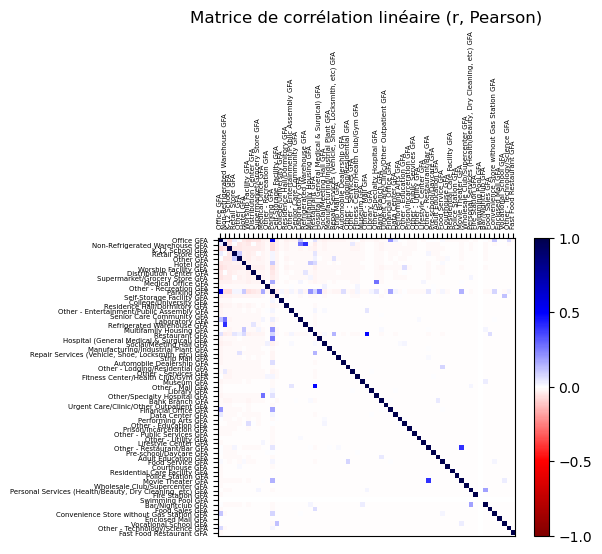

In [90]:
plt.style.use('default')
plt.matshow(df_corr, cmap='seismic_r', vmin=-1, vmax=1)
ticks = range(len(df_corr.columns))
plt.xticks(ticks,
           fontsize=5,
           labels=df_corr.columns,
           rotation=90)
plt.yticks(ticks, fontsize=5, labels=df_corr.columns)
plt.tick_params(bottom=False)
plt.colorbar(shrink=0.8, ticks=[-1, -0.5, 0, 0.5, 1])
plt.title('Matrice de corrélation linéaire (r, Pearson)')
plt.show()

Affichage des coefficients r triés :

In [91]:
df_corr_2 = pd.DataFrame(columns=['corrélation', 'var1', 'var2'])    # dataframe à 3 colonnes : 'corrélation', 'var1', 'var2'
for i in range(df_corr.shape[0]):
    for j in range(i):
        df_corr_2 = df_corr_2.append({'corrélation': df_corr.iloc[i,j], 'var1': df_corr.columns[i], 'var2': df_corr.columns[j]}, ignore_index=True)
df_corr_2 = df_corr_2.sort_values('corrélation', ascending=False, inplace=False)
df_corr_2 = df_corr_2.reset_index(drop=True)
df_corr_2.dropna(subset=['corrélation'], inplace=True)

In [92]:
df_corr_2.head(50)

,corrélation,var1,var2
0,0.569861,Parking GFA,Office GFA
1,0.490614,Other - Mall GFA,Restaurant GFA
2,0.411846,Refrigerated Warehouse GFA,Non-Refrigerated Warehouse GFA
3,0.399859,Movie Theater GFA,Other - Restaurant/Bar GFA
4,0.278451,Laboratory GFA,Non-Refrigerated Warehouse GFA
5,0.274954,Other/Specialty Hospital GFA,Medical Office GFA
6,0.259069,Hospital (General Medical & Surgical) GFA,Parking GFA
7,0.204518,Multifamily Housing GFA,Parking GFA
8,0.204109,Financial Office GFA,Office GFA
9,0.184884,Bar/Nightclub GFA,"Personal Services (Health/Beauty, Dry Cleaning..."


In [93]:
df_corr_2.tail(10)

,corrélation,var1,var2
1881,-0.043129,Parking GFA,Distribution Center GFA
1882,-0.044883,Worship Facility GFA,Non-Refrigerated Warehouse GFA
1883,-0.046659,Hotel GFA,Office GFA
1884,-0.047275,Supermarket/Grocery Store GFA,Office GFA
1885,-0.050800,K-12 School GFA,Non-Refrigerated Warehouse GFA
1886,-0.055181,Parking GFA,Worship Facility GFA
1887,-0.060832,Worship Facility GFA,Office GFA
1888,-0.064020,Parking GFA,K-12 School GFA
1889,-0.067733,Parking GFA,Non-Refrigerated Warehouse GFA
1890,-0.070408,K-12 School GFA,Office GFA


Conclusion sur les corrélations :  
les corrélations entre variables sont rares (le heatmap est blanc sauf sur la diagonale et quelques rares occurences de corrélation).

## Train test split 

POUR LE NOTEBOOK FINAL IL FAUDRA FAIRE LE SPLIT PLUS TOT (avant le nettoyage)  
IL FAUDRA FAIRE LE MEME NETTOYAGE SUR LES JEUX TRAIN ET TEST

POUR L'INSTANT ON NE TRAVAILLE QU'A LA PREDICTION DE SiteEUI(kBtu/sf)

##### Variables à prédire :

In [94]:
y2 = df1[['SiteEnergyUse(kBtu)']].copy()

##### Variables explicatives :

In [95]:
X2 = df1[liste_variables_PropertyUseTypes_GFA].copy()

##### Split :

In [96]:
X_train_EU, X_test_EU, y_train_EU, y_test_EU = train_test_split(X2, y2, test_size=0.2, random_state=0)

In [97]:
y_train_EU

,SiteEnergyUse(kBtu)
3162,1.746374e+07
953,1.128179e+06
2637,1.244150e+06
29,4.456714e+06
1126,1.471914e+06
...,...
1045,1.454688e+05
1192,2.050601e+06
2120,4.302456e+06
580,6.905295e+05


In [98]:
X_train_EU

,Office GFA,Non-Refrigerated Warehouse GFA,K-12 School GFA,Retail Store GFA,Other GFA,Hotel GFA,Worship Facility GFA,Distribution Center GFA,Supermarket/Grocery Store GFA,Medical Office GFA,Other - Recreation GFA,Parking GFA,Self-Storage Facility GFA,College/University GFA,Residence Hall/Dormitory GFA,Other - Entertainment/Public Assembly GFA,Senior Care Community GFA,Laboratory GFA,Refrigerated Warehouse GFA,Multifamily Housing GFA,Restaurant GFA,Hospital (General Medical & Surgical) GFA,Social/Meeting Hall GFA,Manufacturing/Industrial Plant GFA,"Repair Services (Vehicle, Shoe, Locksmith, etc) GFA",Strip Mall GFA,Automobile Dealership GFA,Other - Lodging/Residential GFA,Other - Services GFA,Fitness Center/Health Club/Gym GFA,Museum GFA,Other - Mall GFA,Library GFA,Other/Specialty Hospital GFA,Bank Branch GFA,Urgent Care/Clinic/Other Outpatient GFA,Financial Office GFA,Data Center GFA,Performing Arts GFA,Other - Education GFA,Prison/Incarceration GFA,Other - Public Services GFA,Other - Utility GFA,Lifestyle Center GFA,Other - Restaurant/Bar GFA,Pre-school/Daycare GFA,Adult Education GFA,Food Service GFA,Courthouse GFA,Residential Care Facility GFA,Police Station GFA,Movie Theater GFA,Wholesale Club/Supercenter GFA,"Personal Services (Health/Beauty, Dry Cleaning, etc) GFA",Fire Station GFA,Swimming Pool GFA,Bar/Nightclub GFA,Food Sales GFA,Convenience Store without Gas Station GFA,Enclosed Mall GFA,Vocational School GFA,Other - Technology/Science GFA,Fast Food Restaurant GFA
3162,400536,0,0,0,7177,0,0,0,0,0,0,182439,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
953,0,0,0,0,0,0,30000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2637,0,0,0,0,0,22452,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29,0,0,0,0,0,47994,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1126,31800,8200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0,15000,0,25000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1192,27118,12697,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2120,0,45449,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
580,0,0,0,0,0,0,0,0,0,0,0,0,0,60122,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Imputation, one-hot encoding, recalibrage

Imputation : non pertinent.  
One-hot encoding : non pertinent car toutes les variables sont quantitatives.  
Recalibrage : non pertinent, on part sur l'hypothèse que l'EnergyUse est proportionnel à la surface.  

## Régression linéaire simple

In [99]:
lin_reg = LinearRegression()

# Entrainement
lin_reg.fit(X_train_EU, y_train_EU)

LinearRegression()

In [100]:
# Test de quelques valeurs prédites
some_data = X_train_EU.iloc[:100]
some_labels = y_train_EU.iloc[:100].copy()
some_data_predicted = lin_reg.predict(some_data)

some_labels['Prédictions'] = some_data_predicted
some_labels.head(10)

,SiteEnergyUse(kBtu),Prédictions
3162,1.746374e+07,2.134375e+07
953,1.128179e+06,1.049352e+06
2637,1.244150e+06,1.635394e+06
29,4.456714e+06,3.953151e+06
1126,1.471914e+06,1.959047e+06
773,1.169395e+06,4.657059e+05
305,4.169432e+06,1.717747e+07
2928,8.957847e+05,8.718379e+05
579,8.523594e+06,7.356245e+06
713,1.967476e+06,1.617803e+06


### Metrics

##### RMSE :

In [101]:
EU_predictions = lin_reg.predict(X_train_EU)
lin_mse = mean_squared_error(y_train_EU, EU_predictions)
lin_rmse = np.sqrt(lin_mse)
arrondi(lin_rmse, puissance10=6)

'6.82e6'

##### MAE :

In [102]:
lin_mae = mean_absolute_error(y_train_EU, EU_predictions)
arrondi(lin_mae, puissance10=6)

'2.88e6'

##### R² :

In [103]:
#R² par la méthode score() du transformateur
arrondi(lin_reg.score(X_train_EU, y_train_EU), 5)

0.95281

In [104]:
#R² par la fonction r2_score de metrics
arrondi(r2_score(y_train_EU, EU_predictions))

0.953

### Scatter plot

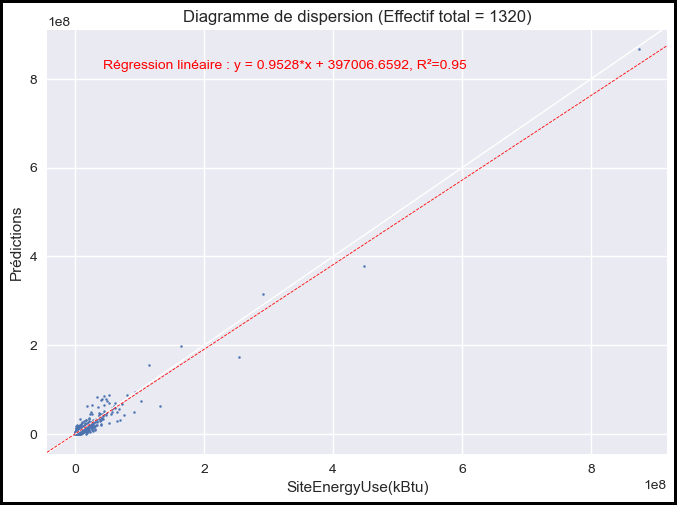

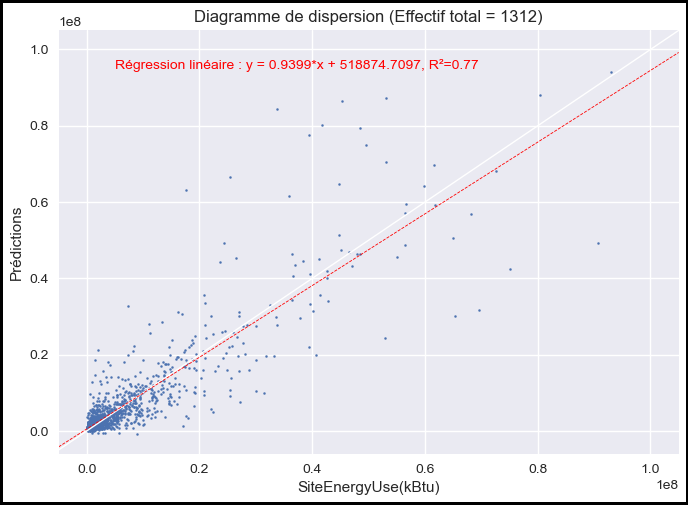

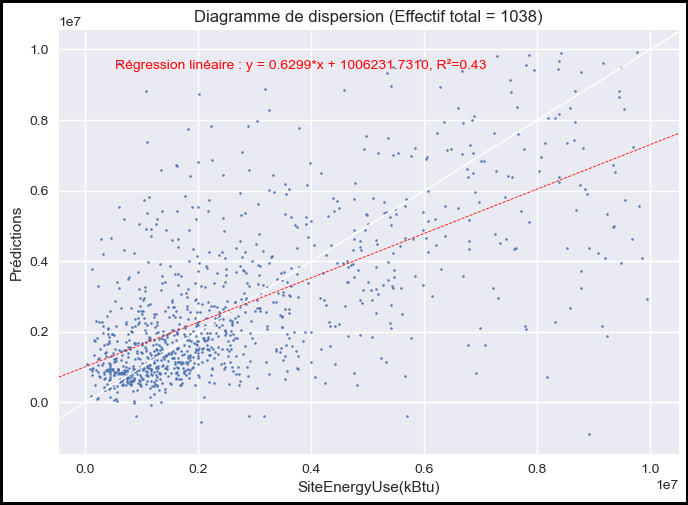

In [105]:
ser_predictions = pd.Series(np.squeeze(EU_predictions), name='Prédictions')
scatter_plot(ser_x=y_train_EU.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, ligne_diagonale=True)
scatter_plot(ser_x=y_train_EU.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=1e8, max_y=1e8, ligne_diagonale=True)
scatter_plot(ser_x=y_train_EU.reset_index().iloc[:,1], ser_y=ser_predictions, alpha=1, max_x=1e7, max_y=1e7, ligne_diagonale=True)

### Analyse des paramètres du modèle

In [106]:
lin_reg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [107]:
lin_reg.intercept_

array([-401966.55724904])

In [108]:
print("lin_reg.coef_ shape :", lin_reg.coef_.shape)
coefs = lin_reg.coef_

lin_reg.coef_ shape : (1, 63)


In [109]:
df_coefs = pd.DataFrame(coefs.T, columns=['Coefficients LR'], index=liste_modalites_types_1_2_3)
with pd.option_context('display.max_rows', 300, 'display.max_colwidth', None, 'display.max_columns', 100, 'display.precision', 1) :
    display(df_coefs.sort_values(by='Coefficients', ascending=False))


KeyError: 'Coefficients'

### Cross validation

In [ ]:
lin_scores = cross_val_score(lin_reg, X_train_EU, y_train_EU,
                             scoring="neg_root_mean_squared_error", cv=10)
display_scores(-lin_scores, puissance10=6)

In [ ]:
lin_scores = cross_val_score(lin_reg, X_train_EU, y_train_EU,
                             scoring="r2", cv=10)
display_scores(lin_scores)

On passe de RMSE=6.8e6 (validation sur le jeu d'entraînement) à 10.7e6 (validation croisée) en moyenne.  
On passe de R²=0.95 (validation sur le jeu d'entraînement) à 0.68 (validation croisée) en moyenne.  
La généralisation du modèle est mauvaise (surajustement).

## Recalibrage des variables

In [ ]:
# Tracé des variables quantitatives avant recalibrage
plt.style.use('seaborn')
X_train_EU.hist(bins=100, figsize=(30,21))
plt.show()

In [ ]:
X_train_EU['Office GFA'].hist(bins=100)
plt.show()

Histogrammes avec forte densité sur GFA=0 car une grande proportion de variables vaut 0.  
Rappel : il y a **{{X_train_EU.shape[0]}}** lignes dans le dataframe X_train_EU.

### Transformation = QuantileTransformer

In [110]:
qt = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
X_train_EU_qt = qt.fit_transform(X_train_EU)

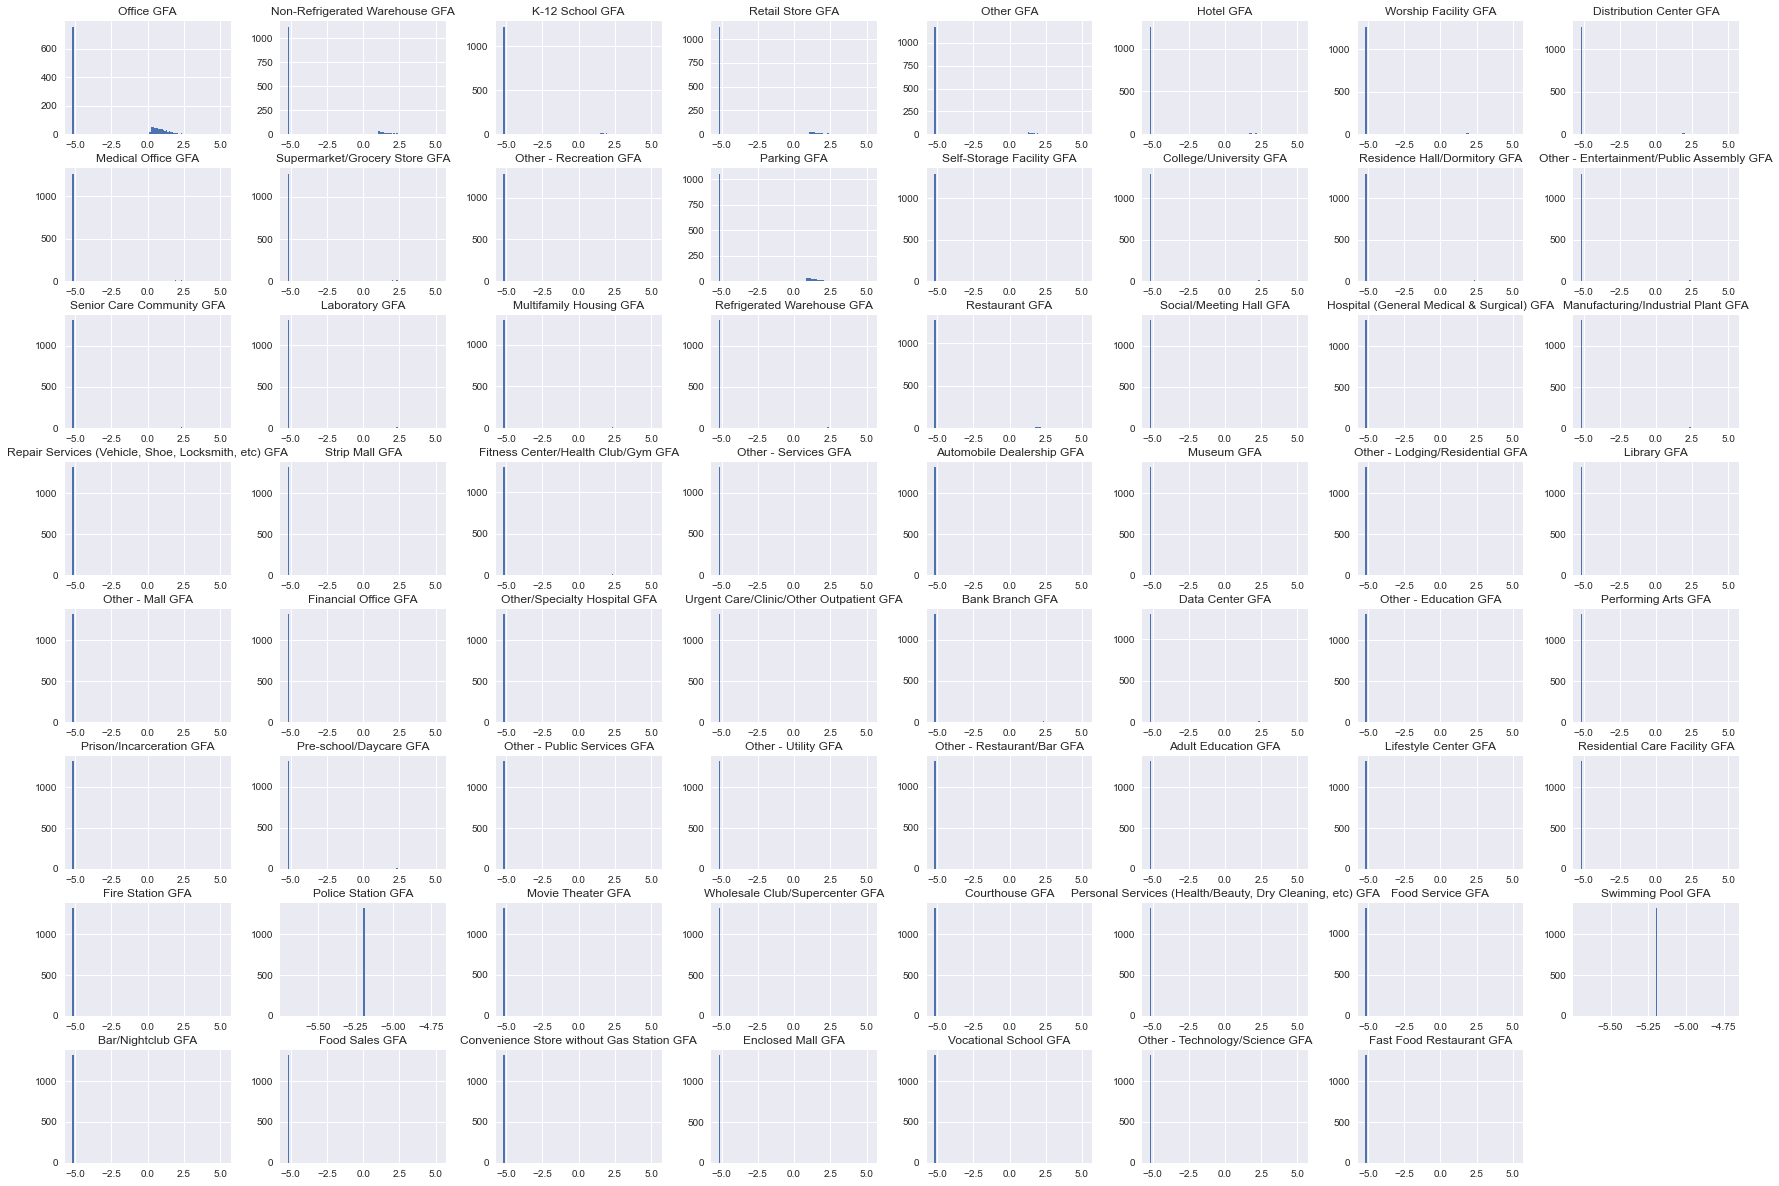

In [110]:
# Tracé des variables quantitatives après recalibrage
df_qt = pd.DataFrame(X_train_EU_qt, columns=X_train_EU.columns)

plt.style.use('seaborn')
df_qt.hist(bins=100, figsize=(30,21));

In [111]:
df_qt['Office GFA'].hist(bins=100);

KeyError: 'Office GFA'

##### Régression linéaire simple :

In [112]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_EU_qt, y_train_EU)
EU_predictions = lin_reg.predict(X_train_EU_qt)
print("R² =", arrondi(r2_score(y_train_EU, EU_predictions)))

R² = 0.237


### Transformation = StandardScaler

In [113]:
ss = StandardScaler()
X_train_EU_ss = ss.fit_transform(X_train_EU)

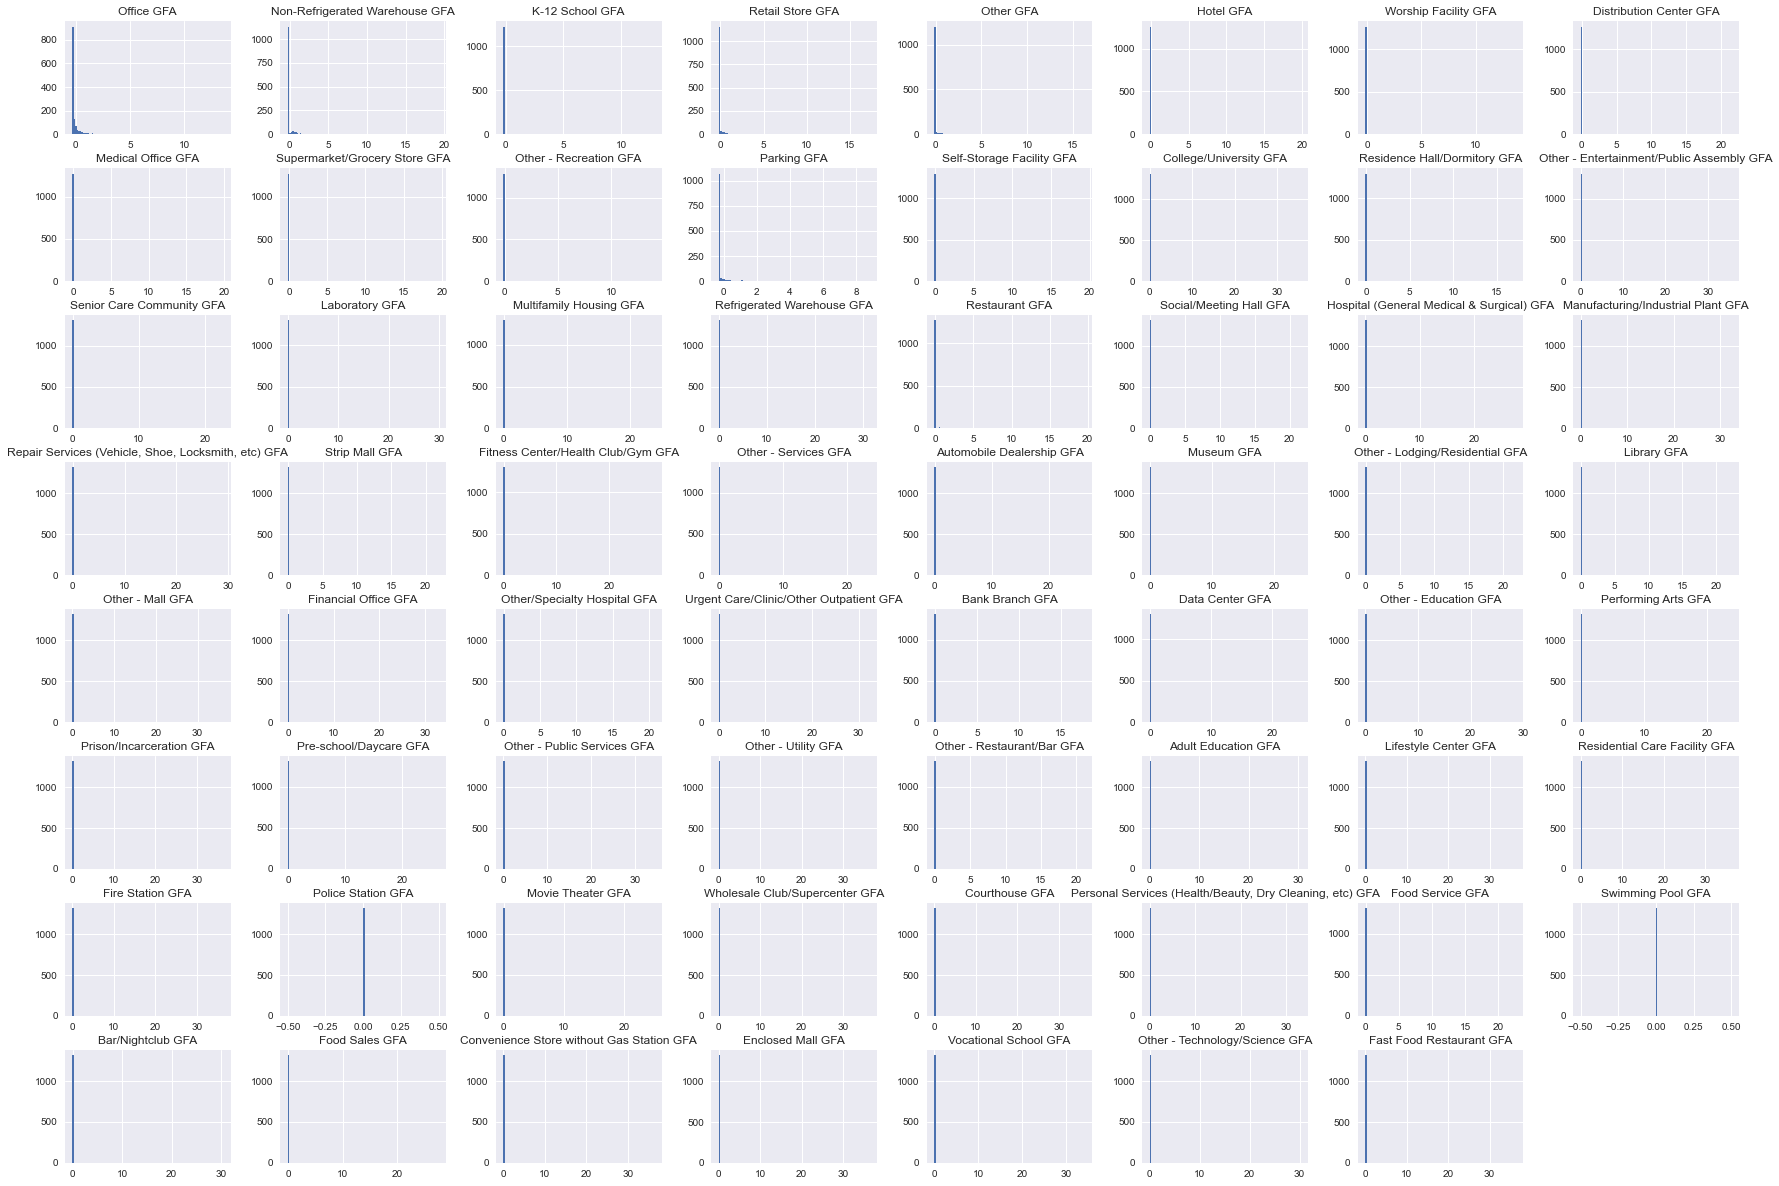

In [114]:
# Tracé des variables quantitatives après recalibrage
df_ss = pd.DataFrame(X_train_EU_ss, columns=X_train_EU.columns)

plt.style.use('seaborn')
df_ss.hist(bins=100, figsize=(30,21));

In [114]:
df_ss['Office GFA'].hist(bins=100);

NameError: name 'df_ss' is not defined

##### Régression linéaire simple :

In [115]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_EU_ss, y_train_EU)
EU_predictions = lin_reg.predict(X_train_EU_ss)
print("R² =", arrondi(r2_score(y_train_EU, EU_predictions)))

R² = 0.953


Comme attendu, on retrouve le même R² que pour la régression linéaire simple sans scaler, car le scaler fait une transformation linéaire.

##### Cross validation

In [116]:
lin_scores = cross_val_score(lin_reg, X_train_EU_ss, y_train_EU,
                             scoring="neg_root_mean_squared_error", cv=10)
display_scores(-lin_scores, puissance10=6)

Scores: 165723500.53e6 748005037749.28e6 376723047445.77e6 1162424128363.86e6 14.87e6 6.24e6 78023294686.31e6 343648874537.80e6 70790538835930.64e6 9.75e6 
Mean: 7349952894224.50e6
Standard deviation: 22294142621535.61e6


In [117]:
lin_scores = cross_val_score(lin_reg, X_train_EU_ss, y_train_EU,
                             scoring="r2", cv=10)
display_scores(lin_scores)

Scores: -141000000000000.0 -5.48e+21 -1.95e+20 -1.77e+22 0.755 0.691 -1.06e+18 -1.08e+21 -3.17e+24 0.586 
Mean: -3.19e+23
Standard deviation: 999999999999999983222784


Surajustement énorme.

### Transformation = MinMaxScaler

In [118]:
mms = MinMaxScaler(feature_range=(0,1))
X_train_EU_mms = mms.fit_transform(X_train_EU)

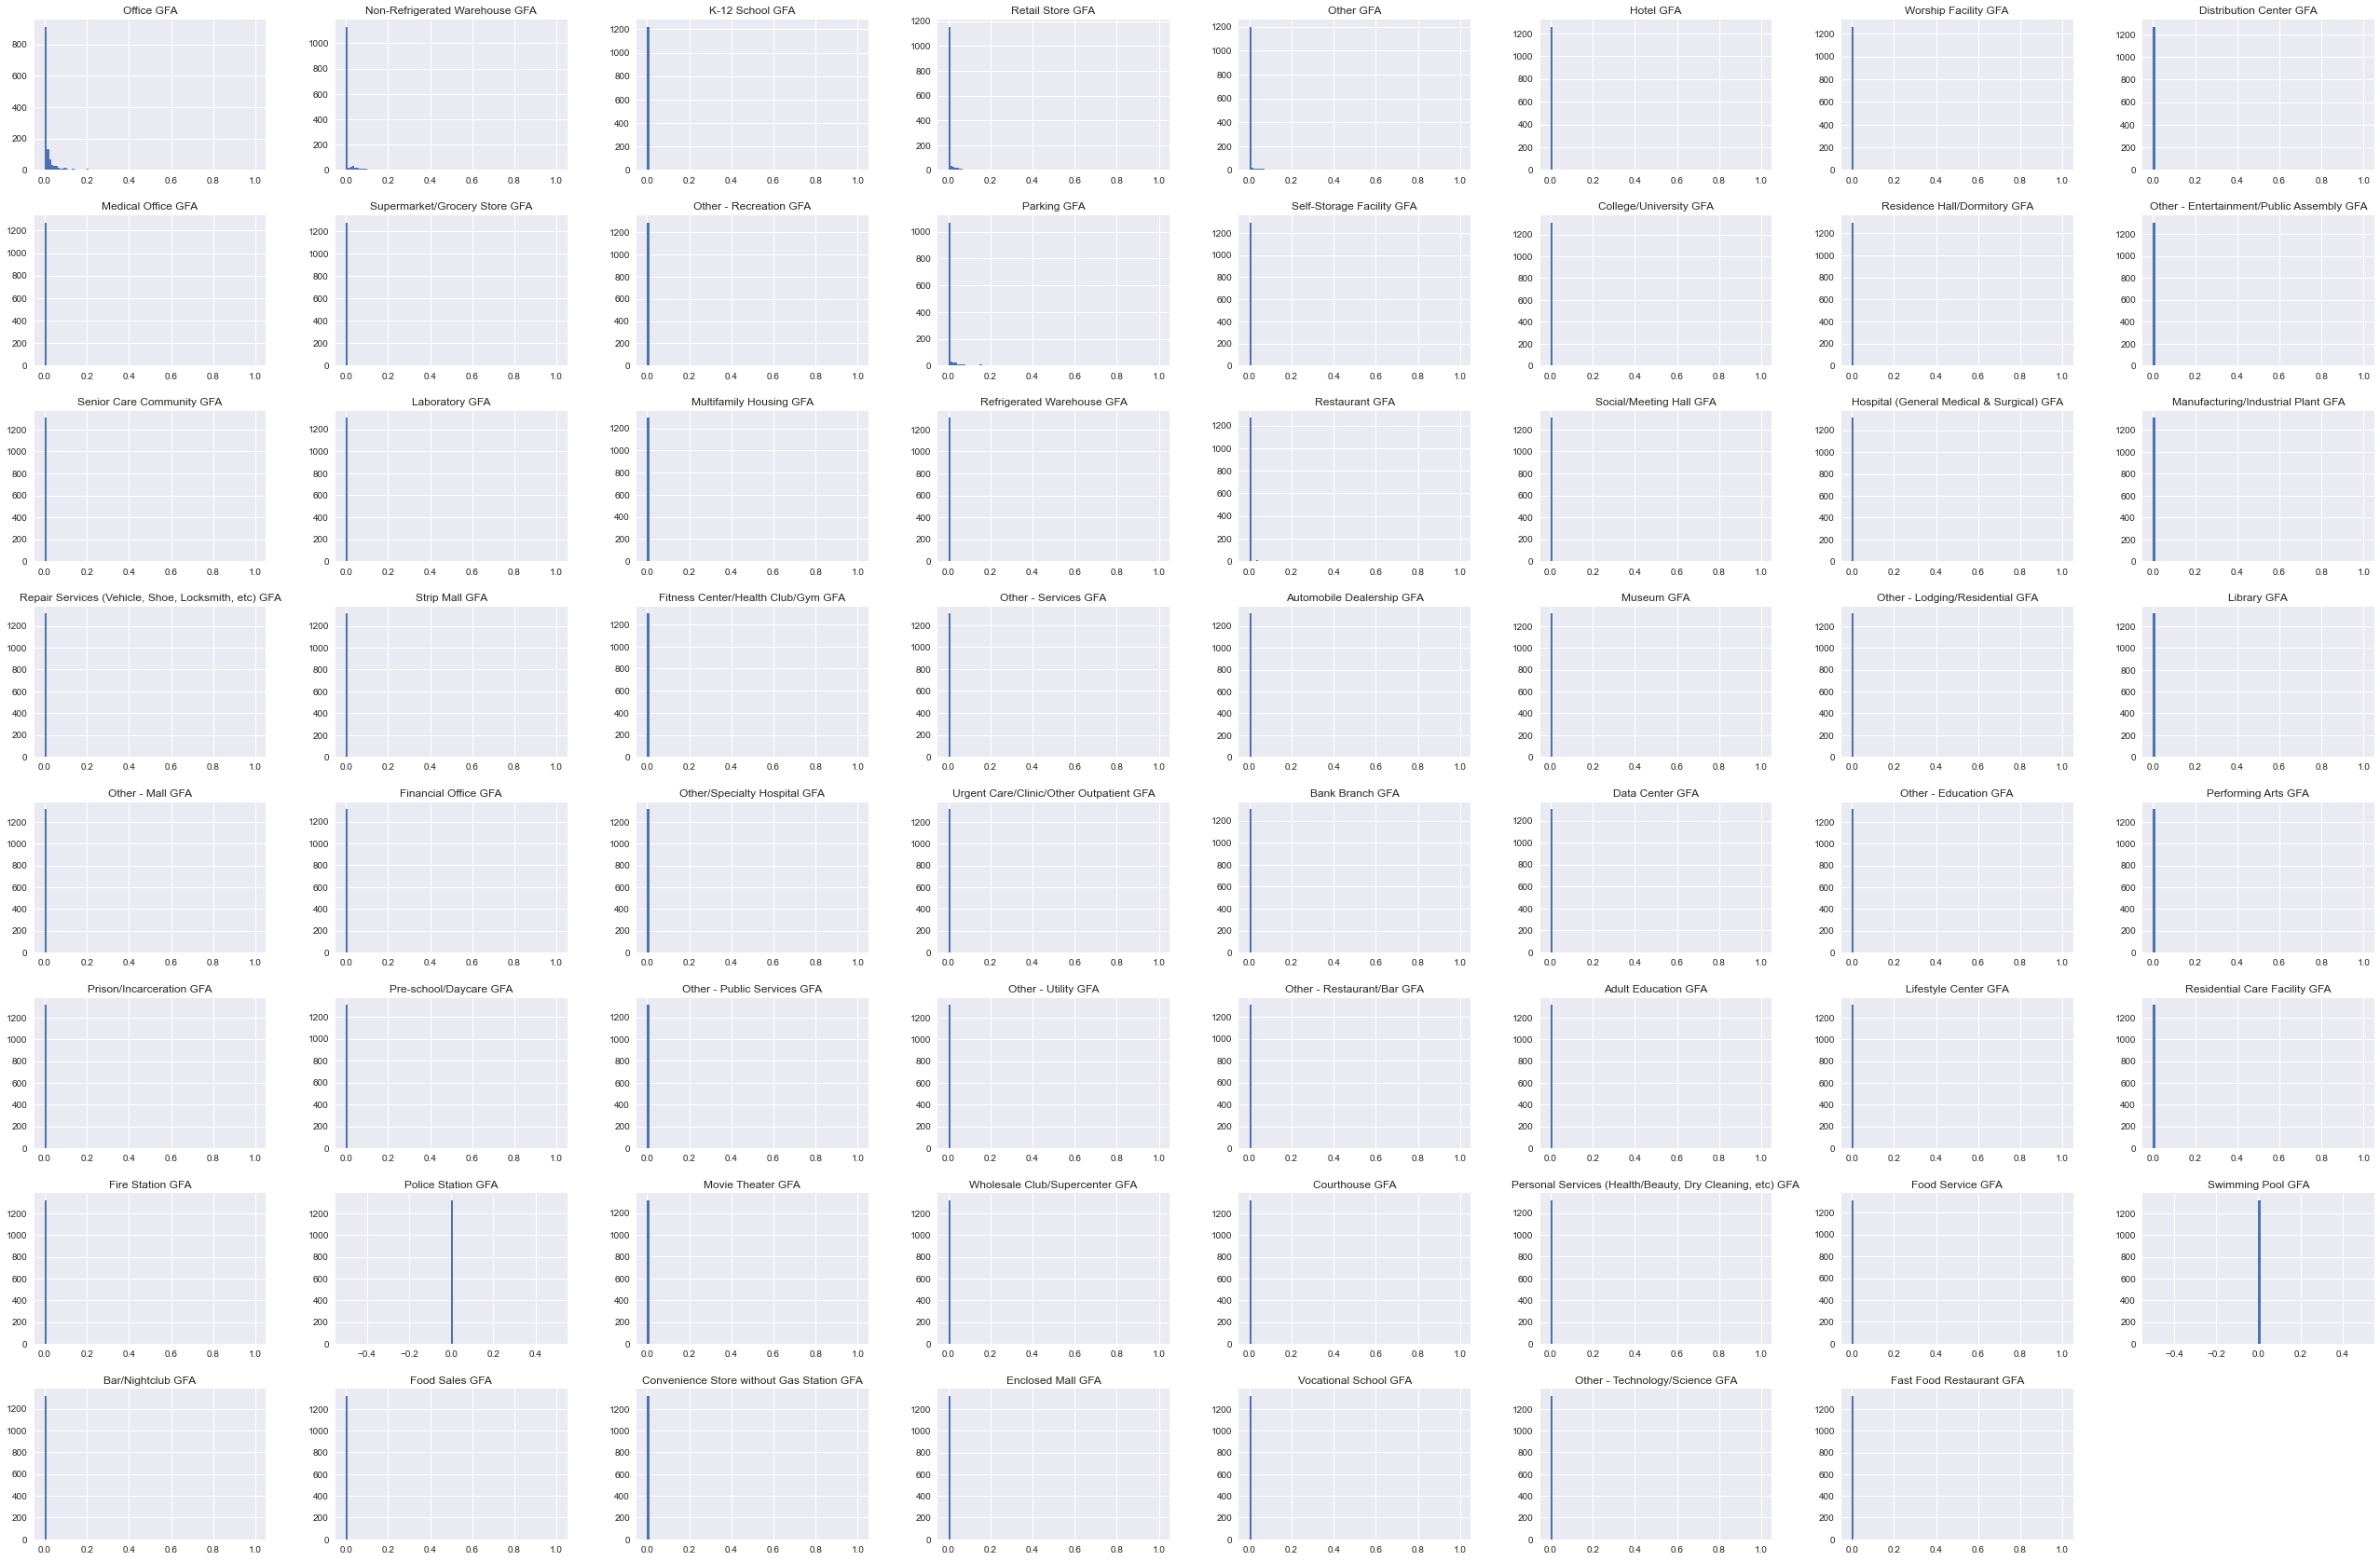

In [120]:
# Tracé des variables quantitatives après recalibrage
df_mms = pd.DataFrame(X_train_EU_mms, columns=X_train_EU.columns)

plt.style.use('seaborn')
df_mms.hist(bins=100, figsize=(45,30))
plt.show()

In [119]:
df_mms['Office GFA'].hist(bins=100);

NameError: name 'df_mms' is not defined

##### Régression linéaire simple :

In [120]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_EU_mms, y_train_EU)
EU_predictions = lin_reg.predict(X_train_EU_mms)
print("R² =", arrondi(r2_score(y_train_EU, EU_predictions), 5))

R² = 0.95281


Comme attendu, on retrouve le même R² que pour la régression linéaire simple sans scaler, car le scaler fait une transformation linéaire.

In [121]:
lin_scores = cross_val_score(lin_reg, X_train_EU_mms, y_train_EU,
                             scoring="neg_root_mean_squared_error", cv=10)
display_scores(-lin_scores, puissance10=6)

Scores: 5.54e6 8.69e6 10.08e6 5.70e6 14.87e6 6.24e6 16.12e6 6.76e6 2782473056992.58e6 9.75e6 
Mean: 278247305707.63e6
Standard deviation: 879895238811.86e6


In [122]:
lin_scores = cross_val_score(lin_reg, X_train_EU_mms, y_train_EU,
                             scoring="r2", cv=10)
display_scores(lin_scores)

Scores: 0.842 0.261 0.86 0.575 0.755 0.691 0.955 0.583 -4.89e+21 0.586 
Mean: -4.89e+20
Standard deviation: 1550000000000000000000


### Conclusion sur le recalibrage des variables

Dans la deuxième approche du problème, le point fort est de tenir compte des superficies spécifiques des types de buisness de chaque propriété.  
En recalibrant les variables avec les scalers classiques, on perd le sens physique des données d'entrée.

## Ridge regression

### Variables non recalibrées

In [123]:
ridge_nr = RidgeCV(alphas=np.logspace(8, 12, 100), cv=10)    # 100 valeurs alpha entre 1e8 et 1e12
ridge_nr.fit(X_train_EU, y_train_EU)

RidgeCV(alphas=array([1.00000000e+08, 1.09749877e+08, 1.20450354e+08, 1.32194115e+08, 1.45082878e+08, 1.59228279e+08, 1.74752840e+08, 1.91791026e+08, 2.10490414e+08,
       2.31012970e+08, 2.53536449e+08, 2.78255940e+08, 3.05385551e+08, 3.35160265e+08, 3.67837977e+08, 4.03701726e+08, 4.43062146e+08, 4.86260158e+08,
       5.33669923e+08, 5.85702082e+08, 6.42807312e+08, 7.05480231e+0...
       8.11130831e+10, 8.90215085e+10, 9.77009957e+10, 1.07226722e+11, 1.17681195e+11, 1.29154967e+11, 1.41747416e+11, 1.55567614e+11, 1.70735265e+11,
       1.87381742e+11, 2.05651231e+11, 2.25701972e+11, 2.47707636e+11, 2.71858824e+11, 2.98364724e+11, 3.27454916e+11, 3.59381366e+11, 3.94420606e+11,
       4.32876128e+11, 4.75081016e+11, 5.21400829e+11, 5.72236766e+11, 6.28029144e+11, 6.89261210e+11, 7.56463328e+11, 8.30217568e+11, 9.11162756e+11,
       1.00000000e+12]),
        cv=10)

In [124]:
ridge_nr.alpha_

5462277217.684337

In [125]:
# R²
arrondi(ridge_nr.best_score_, 5)

0.69732

In [126]:
arrondi(float(ridge_nr.intercept_), puissance10=6)

'0.03e6'

In [143]:
print(ridge_nr.coef_.shape)
ridge_nr.coef_

(1, 63)


array([[ 5.83707064e+01,  5.81358489e+01,  3.81295935e+01,  3.25598251e+01,  1.19136882e+02,  8.97853255e+01,  3.55794340e+01,  2.87566273e+01,  1.68321261e+02,
         1.08897553e+02,  1.90928780e+02, -1.20867646e+01,  1.18420355e+01,  9.28879289e+01,  4.07934535e+01,  4.04673750e+01,  1.11055087e+02,  4.75775671e+02,
         3.78156961e+01,  6.03027585e+01,  1.80525393e+02,  1.95486228e+02,  1.16677451e+02,  3.75503331e+01,  5.05608274e+01,  8.93281974e+01,  4.33956551e+01,
         2.08154652e+01,  1.38827190e+02,  5.87480394e+01,  8.65535728e+01,  4.93890238e+01,  6.42845544e+00,  2.58473922e+02,  1.93140589e+01,  3.17705460e+02,
         2.48270749e+01,  5.80312913e+02,  2.66283549e+01,  2.33247934e+01,  1.72310413e+00,  4.94010508e+01,  3.06155600e+01,  7.07095095e+01,  9.79985340e+01,
         1.48500490e+01,  2.07158861e+01,  2.32025321e+01, -2.25762538e+01,  9.42351228e+00,  0.00000000e+00,  8.28864258e+01,  7.34151450e+01,  1.63691028e+01,
         1.71325790e+01,  0.000000

### Recalibrage par StandardScaler

In [144]:
ridge_ss = RidgeCV(alphas=np.logspace(0, 2, 100), cv=10)    # 100 valeurs alpha entre 1e0 et 1e2
ridge_ss.fit(X_train_EU_ss, y_train_EU)

RidgeCV(alphas=array([  1.        ,   1.04761575,   1.09749877,   1.149757  ,   1.20450354,   1.26185688,   1.32194115,   1.38488637,   1.45082878,   1.51991108,   1.59228279,
         1.66810054,   1.7475284 ,   1.83073828,   1.91791026,   2.009233  ,   2.10490414,   2.20513074,   2.3101297 ,   2.42012826,   2.53536449,   2.65608778,
         2.7825594 ,   2.91505306,   3.05385551,   3.19926714,   3.35160265,   3.51119173,   3.67837977,   3.85352859,   4.03701726,   4....
        21.5443469 ,  22.5701972 ,  23.64489413,  24.77076356,  25.95024211,  27.18588243,  28.48035868,  29.8364724 ,  31.2571585 ,  32.74549163,  34.30469286,
        35.93813664,  37.64935807,  39.44206059,  41.320124  ,  43.28761281,  45.34878508,  47.50810162,  49.77023564,  52.14008288,  54.62277218,  57.22367659,
        59.94842503,  62.80291442,  65.79332247,  68.92612104,  72.20809018,  75.64633276,  79.24828984,  83.02175681,  86.97490026,  91.11627561,  95.45484567,
       100.        ]),
        cv=10)

In [145]:
ridge_ss.alpha_

10.235310218990262

In [146]:
# R²
arrondi(ridge_ss.best_score_, 5)

0.68021

In [147]:
arrondi(float(ridge_ss.intercept_), puissance10=6)

'8.41e6'

In [148]:
print(ridge_ss.coef_.shape)
ridge_ss.coef_

(1, 63)


array([[ 6.98844516e+06,  1.86362807e+06,  1.13688302e+06,  9.64519707e+05,  3.90368229e+06,  4.45891456e+06,  3.40073337e+05,  4.29556837e+05,  1.55228453e+06,
         2.72823984e+06,  1.12536944e+06, -5.74107665e+05,  1.15878512e+05,  2.42088482e+07,  5.27945673e+05,  1.79506332e+06,  1.49145549e+06,  1.01962886e+07,
         3.55499253e+05,  8.90922421e+05,  1.01918974e+06,  1.15153528e+07,  4.75159559e+05,  2.17144481e+05,  2.26872571e+05,  6.59689317e+05,  2.38245247e+05,
         8.29067397e+04,  6.32144822e+05,  2.75445596e+05,  3.68781240e+05,  6.29091664e+05,  5.00341077e+04,  1.12428900e+06,  1.09790583e+05,  1.82580437e+06,
         2.67381021e+05,  2.75287522e+06,  1.20868843e+05,  1.39573080e+05,  3.16999748e+04,  2.12509739e+05,  1.57953554e+05,  6.60194156e+05,  4.57209979e+05,
         7.52326014e+04,  9.48620863e+04,  1.87026415e+05, -8.64398014e+04,  7.07228669e+04,  0.00000000e+00,  2.33089597e+05,  3.74970286e+05,  1.08529765e+05,
         9.29885556e+04,  0.000000

#### Faire une validation croisée "à la main" pour mieux maitriser le fonctionnement interne d'une fonction "tout-en-un" comme RidgeCV :

In [149]:
ridge_ss_test = Ridge(alpha=10.235310218990262) 
scores = cross_val_score(ridge_ss_test, X_train_EU_ss, y_train_EU, 
                         scoring="r2", cv=10)
display_scores(scores, 5)

Scores: 0.84953 0.28502 0.85631 0.58129 0.81692 0.69979 0.888 0.58347 0.65746 0.5843 
Mean: 0.68021
Standard deviation: 0.18468


La moyenne des 10 scores pour R² (0.68021 pour l'instance ridge_ss_test) correspond bien au "best score" retourné par la méthode RidgeCV avec le même alpha.  
L'écart-type plutôt élevé est préoccupant ; il traduit un problème lié aux folds (types de PropertyUsageType mal répartis entre train et test sets de la CV).

Effet du nb de cv sur le R² et son écart-type :

In [150]:
liste_cv = []
liste_mean = []
liste_std = []
for i in range(2, 80):
    ridge_ss_test = Ridge(alpha=10.235310218990262) 
    scores = cross_val_score(ridge_ss_test, X_train_EU_ss, y_train_EU, 
                             scoring="r2", cv=i)
    liste_cv.append(i)
    liste_mean.append(scores.mean())
    liste_std.append(scores.std(ddof=1))

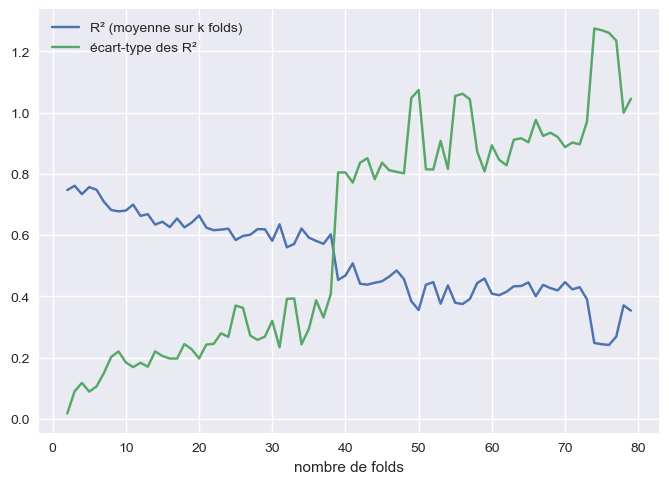

In [151]:
plt.plot(liste_cv, liste_mean)
plt.plot(liste_cv, liste_std)
plt.xlabel('nombre de folds')
plt.legend(['R² (moyenne sur k folds)', 'écart-type des R²']);

La taille du dataset est trop petite pour envisager un nombre de folds trop important.  

#### Plot du R² en fonction de alpha

In [152]:
# calcul de la baseline_R2
lin_scores = cross_val_score(lin_reg, X_train_EU, y_train_EU,
                             scoring="r2", cv=10)
baseline_R2 = lin_scores.mean()
baseline_R2

0.6779641587733864

In [153]:
# calcul des R² pour chaque alpha
liste_alpha = np.logspace(-1, 2, 100)   # 100 valeurs alpha entre 1e-1 et 1e2
liste_R2 = []
liste_baseline = []
for alpha in liste_alpha:  
    ridge_ss_test = Ridge(alpha=alpha) 
    scores = cross_val_score(ridge_ss_test, X_train_EU_ss, y_train_EU, 
                             scoring="r2", cv=10)
    liste_R2.append(scores.mean())
    liste_baseline.append(baseline_R2)

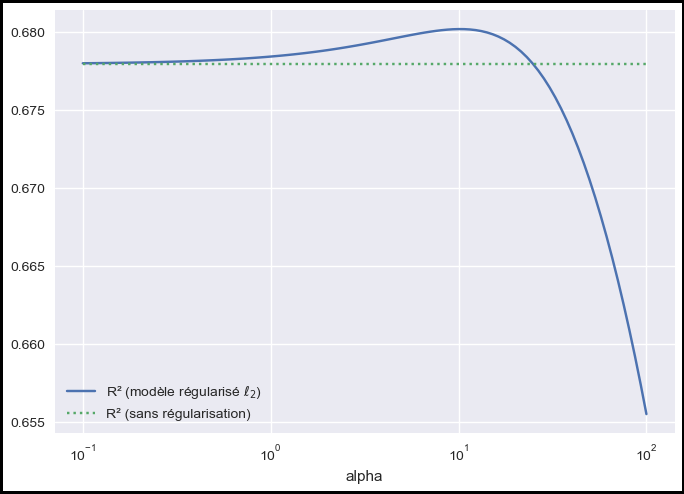

In [154]:
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4)
plt.plot(liste_alpha, liste_R2)
plt.plot(liste_alpha, liste_baseline, linestyle=':')
plt.xlabel('alpha')
plt.xscale("log")
plt.legend(['R² (modèle régularisé '+'$\ell_2$'+')', 'R² (sans régularisation)']);

Le gain obtenu pour le modèle régularisé par rapport au modèle linéaire simple est très faible.  
L'optimum se situe vers alpha = 10.  

### Recalibrage par MinMaxScaler

In [155]:
ridge_mms = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=10)    # 100 valeurs alpha entre 1e0 et 1e2
ridge_mms.fit(X_train_EU_mms, y_train_EU)

RidgeCV(alphas=array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03, 1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03, 3.05385551e-03,
       3.51119173e-03, 4.03701726e-03, 4.64158883e-03, 5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03, 9.32603347e-03, 1.07226722e-02,
       1.23284674e-02, 1.41747416e-02, 1.62975083e-02, 1.87381742e-0...
       2.31012970e+01, 2.65608778e+01, 3.05385551e+01, 3.51119173e+01, 4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01, 7.05480231e+01,
       8.11130831e+01, 9.32603347e+01, 1.07226722e+02, 1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02, 2.15443469e+02, 2.47707636e+02,
       2.84803587e+02, 3.27454916e+02, 3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02, 6.57933225e+02, 7.56463328e+02, 8.69749003e+02,
       1.00000000e+03]),
        cv=10)

In [156]:
ridge_mms.alpha_

0.004641588833612782

In [157]:
# R²
arrondi(ridge_mms.best_score_)

0.679

In [158]:
arrondi(float(ridge_mms.intercept_), puissance10=6)

'-0.38e6'

In [159]:
print(ridge_ss.coef_.shape)
display(ridge_mms.coef_)

(1, 63)


array([[ 9.90263684e+07,  3.63103851e+07,  1.51367826e+07,  1.71164536e+07,  6.50736039e+07,  8.99594649e+07,  4.92754847e+06,  9.50403402e+06,  3.09609199e+07,
         5.56031093e+07,  1.61429283e+07, -6.47957204e+06,  2.42722612e+06,  8.62695611e+08,  9.28493435e+06,  6.42050852e+07,  3.43924237e+07,  3.06975674e+08,
         1.12670375e+07,  2.19711612e+07,  2.04316172e+07,  3.21282116e+08,  1.04044936e+07,  7.21116508e+06,  6.75391006e+06,  1.46541945e+07,  6.79191008e+06,
         1.89176460e+06,  1.50369822e+07,  8.08946448e+06,  9.10484648e+06,  2.25829113e+07,  1.19098830e+06,  2.34566906e+07,  2.09220793e+06,  5.94915088e+07,
         8.79093581e+06,  6.83653930e+07,  2.88327079e+06,  4.16341516e+06,  1.22657932e+06,  7.40630564e+06,  5.82952751e+06,  2.41009090e+07,  9.76820449e+06,
         2.07439082e+06,  2.95373861e+06,  4.33982424e+06, -3.23493087e+06,  2.64927444e+06,  0.00000000e+00,  6.55401523e+06,  1.37415153e+07,  3.66543542e+06,
         3.46103608e+06,  0.000000

Conclusion sur MinMaxScaler vs StandardScaler : le R² n'a pas été amélioré.  

### Conclusion sur les régressions ridge

Le gain de R² obtenu par l'ajout d'un régularisateur ridge est faible (0.678 vs 0.679). En particulier car les variables sont très rarement corrélées entre elles (cf conclusion concernant la heatmap).

## Régression LASSO (variables recalibrées par StandardScaler)

### Fonction LassoCV

In [160]:
lasso_ss = LassoCV(alphas=np.logspace(1, 6, 100), cv=10, tol=1e-10)    # valeurs alpha entre 1e-10 et 1e3
lasso_ss.fit(X_train_EU_ss, y_train_EU.iloc[:,0])

LassoCV(alphas=array([1.00000000e+01, 1.12332403e+01, 1.26185688e+01, 1.41747416e+01, 1.59228279e+01, 1.78864953e+01, 2.00923300e+01, 2.25701972e+01, 2.53536449e+01,
       2.84803587e+01, 3.19926714e+01, 3.59381366e+01, 4.03701726e+01, 4.53487851e+01, 5.09413801e+01, 5.72236766e+01, 6.42807312e+01, 7.22080902e+01,
       8.11130831e+01, 9.11162756e+01, 1.02353102e+02, 1.14975700e+0...
       4.32876128e+04, 4.86260158e+04, 5.46227722e+04, 6.13590727e+04, 6.89261210e+04, 7.74263683e+04, 8.69749003e+04, 9.77009957e+04, 1.09749877e+05,
       1.23284674e+05, 1.38488637e+05, 1.55567614e+05, 1.74752840e+05, 1.96304065e+05, 2.20513074e+05, 2.47707636e+05, 2.78255940e+05, 3.12571585e+05,
       3.51119173e+05, 3.94420606e+05, 4.43062146e+05, 4.97702356e+05, 5.59081018e+05, 6.28029144e+05, 7.05480231e+05, 7.92482898e+05, 8.90215085e+05,
       1.00000000e+06]),
        cv=10, tol=1e-10)

In [161]:
lasso_ss.alpha_

10.0

In [162]:
lasso_ss.n_iter_

43

In [163]:
arrondi(lasso_ss.intercept_, puissance10=6)

'8.41e6'

Malgré le paramètre tol très faible, je ne parviens pas à avoir un calcul de LassoCV qui termine sur les valeurs obtenues avec la fonction Lasso.

### Plot du R² en fonction de alpha (fonction Lasso)

In [164]:
# calcul des R² pour chaque alpha
liste_alpha = np.logspace(2, 5.3, 300)   # 300 valeurs alpha
liste_R2 = []
liste_baseline = []
for alpha in liste_alpha:  
    lasso_ss = Lasso(alpha=alpha) 
    scores = cross_val_score(lasso_ss, X_train_EU_ss, y_train_EU, 
                             scoring="r2", cv=10)
    liste_R2.append(scores.mean())
    liste_baseline.append(baseline_R2)

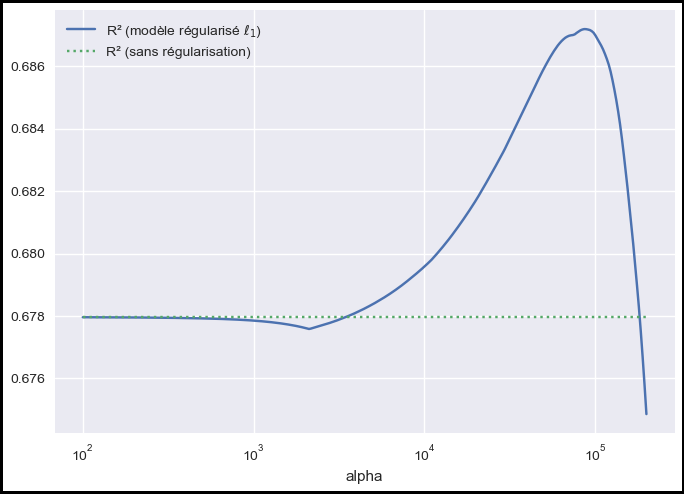

In [165]:
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4)
plt.plot(liste_alpha, liste_R2)
plt.plot(liste_alpha, liste_baseline, linestyle=':')
plt.xlabel('alpha')
plt.xscale("log")
plt.legend(['R² (modèle régularisé '+'$\ell_1$'+')', 'R² (sans régularisation)']);

In [166]:
indice_du_maxi = liste_R2.index(max(liste_R2))
print("Valeur optimale de alpha =", liste_alpha[indice_du_maxi])
print("Valeur optimale de R² =", arrondi(liste_R2[indice_du_maxi]))

Valeur optimale de alpha = 86255.33240735748
Valeur optimale de R² = 0.687


In [167]:
lasso_optimum = Lasso(alpha=liste_alpha[indice_du_maxi]) 
lasso_optimum.fit(X_train_EU_ss, y_train_EU)

Lasso(alpha=86255.33240735748)

In [168]:
arrondi(float(lasso_optimum.intercept_), puissance10=6)

'8.41e6'

In [169]:
lasso_optimum.coef_

array([ 6.65293960e+06,  1.75931622e+06,  9.75909475e+05,  8.26976127e+05,  3.77873728e+06,  4.31739995e+06,  1.80935263e+05,  3.01366130e+05,  1.42573133e+06,
        2.54920934e+06,  1.01901673e+06, -1.60683123e+05,  0.00000000e+00,  2.42788388e+07,  4.07729437e+05,  1.71481485e+06,  1.37958855e+06,  1.02230052e+07,
        3.06038948e+05,  7.14613127e+05,  9.18447406e+05,  1.14118360e+07,  3.78376318e+05,  1.07180815e+05,  1.16073907e+05,  5.54284405e+05,  8.83273230e+04,
        0.00000000e+00,  5.32862347e+05,  1.57565911e+05,  2.65024666e+05,  5.95001322e+05,  0.00000000e+00,  1.04157451e+06,  0.00000000e+00,  1.73363751e+06,
        1.58759450e+05,  2.64694030e+06,  2.93254116e+04,  3.51995532e+04,  0.00000000e+00,  1.10660628e+05,  6.08818327e+04,  5.70784825e+05,  3.91990569e+05,
        0.00000000e+00,  0.00000000e+00,  8.62136500e+04, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.01128843e+04,  2.79580236e+05,  1.86893220e+04,
        0.00000000e+00,  0.00000000e+00,

Le lasso met un grand nombre de coefficients à 0.

In [170]:
df_coefs['Coefficients Lasso'] = lasso_optimum.coef_.T

In [171]:
df_coefs

,Coefficients LR,Coefficients Lasso
Office,5.912306e+01,6.652940e+06
Non-Refrigerated Warehouse,5.864642e+01,1.759316e+06
K-12 School,4.131505e+01,9.759095e+05
Retail Store,3.377340e+01,8.269761e+05
Other,1.216419e+02,3.778737e+06
Hotel,9.074296e+01,4.317400e+06
Worship Facility,4.837729e+01,1.809353e+05
Distribution Center,3.324282e+01,3.013661e+05
Supermarket/Grocery Store,1.840517e+02,1.425731e+06
Medical Office,1.073555e+02,2.549209e+06


Le gain de R² obtenu par l'ajout d'un régularisateur ridge est faible.  
Toutes choses égales par ailleurs (scaling SS, CV=10 dans les modèles), les R² sont :
- 0.678 (sans régularisation),  
- 0.679 (Ridge),
- 0.687 (Lasso).

## Arbres de décision

In [172]:
tree_reg = DecisionTreeRegressor(random_state=0)
tree_reg.fit(X_train_EU, y_train_EU)

DecisionTreeRegressor(random_state=0)

##### RMSE / validation croisée

In [173]:
scores = cross_val_score(tree_reg, X_train_EU, y_train_EU, 
                         scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, puissance10=6)

Scores: 7.67e6 7.59e6 22.04e6 6.71e6 18.33e6 9.84e6 73.49e6 8.97e6 37.51e6 12.49e6 
Mean: 20.47e6
Standard deviation: 20.91e6


##### R² / validation croisée

In [174]:
scores = cross_val_score(tree_reg, X_train_EU, y_train_EU, 
                         scoring="r2", cv=10)
display_scores(scores)

Scores: 0.698 0.435 0.332 0.411 0.628 0.23 0.0629 0.266 0.111 0.32 
Mean: 0.349
Standard deviation: 0.203


Ce modèle n'est pas adapté à nos données.

## Forêts aléatoires

In [175]:
forest_reg = RandomForestRegressor(n_estimators=20, max_features=20, random_state=0)
forest_reg.fit(X_train_EU, y_train_EU.iloc[:,0])

RandomForestRegressor(max_features=20, n_estimators=20, random_state=0)

In [176]:
forest_predictions = forest_reg.predict(X_train_EU)
forest_mse = mean_squared_error(y_train_EU, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
arrondi(forest_rmse, puissance10=6)     # attention : test sur jeu d'entrainement

'10.37e6'

In [177]:
forest_scores = cross_val_score(forest_reg, X_train_EU, y_train_EU.iloc[:,0],
                                scoring="neg_root_mean_squared_error", cv=10)
display_scores(-forest_scores, puissance10=6)

Scores: 7.13e6 5.99e6 20.16e6 5.47e6 19.14e6 7.66e6 71.46e6 9.89e6 36.81e6 9.94e6 
Mean: 19.37e6
Standard deviation: 20.70e6


In [178]:
forest_scores = cross_val_score(forest_reg, X_train_EU, y_train_EU.iloc[:,0],
                                scoring="r2", cv=10)
display_scores(-forest_scores)

Scores: -0.739 -0.649 -0.441 -0.609 -0.594 -0.534 -0.114 -0.108 -0.144 -0.569 
Mean: -0.45
Standard deviation: 0.239


C'est nul.

### GridSearchCV

##### Scoring = -RMSE :

In [237]:
param_grid = [
    {'max_features': [7, 15, 30], 'n_estimators': [15, 30, 60], 'random_state': [0]}
            ]
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_root_mean_squared_error', return_train_score=True)
grid_search.fit(X_train_EU, y_train_EU.iloc[:,0])

GridSearchCV(cv=10,
             estimator=RandomForestRegressor(max_features=20, n_estimators=20,
                                             random_state=0),
             param_grid=[{'max_features': [7, 15, 30],
                          'n_estimators': [15, 30, 60], 'random_state': [0]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [238]:
grid_search.best_params_

{'max_features': 30, 'n_estimators': 30, 'random_state': 0}

In [239]:
grid_search.best_estimator_

RandomForestRegressor(max_features=30, n_estimators=30, random_state=0)

In [240]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("RMSE =", arrondi(-mean_score, puissance10=6), params)

RMSE = 19.56e6 {'max_features': 7, 'n_estimators': 15, 'random_state': 0}
RMSE = 19.23e6 {'max_features': 7, 'n_estimators': 30, 'random_state': 0}
RMSE = 19.16e6 {'max_features': 7, 'n_estimators': 60, 'random_state': 0}
RMSE = 19.80e6 {'max_features': 15, 'n_estimators': 15, 'random_state': 0}
RMSE = 19.18e6 {'max_features': 15, 'n_estimators': 30, 'random_state': 0}
RMSE = 19.00e6 {'max_features': 15, 'n_estimators': 60, 'random_state': 0}
RMSE = 19.09e6 {'max_features': 30, 'n_estimators': 15, 'random_state': 0}
RMSE = 18.93e6 {'max_features': 30, 'n_estimators': 30, 'random_state': 0}
RMSE = 18.97e6 {'max_features': 30, 'n_estimators': 60, 'random_state': 0}



##### Scoring = R² :

In [241]:
param_grid = [{'max_features': [7, 15, 30], 'n_estimators': [15, 30, 60], 'random_state': [0]}]
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='r2', return_train_score=True)
grid_search.fit(X_train_EU, y_train_EU.iloc[:,0])

GridSearchCV(cv=10,
             estimator=RandomForestRegressor(max_features=20, n_estimators=20,
                                             random_state=0),
             param_grid=[{'max_features': [7, 15, 30],
                          'n_estimators': [15, 30, 60], 'random_state': [0]}],
             return_train_score=True, scoring='r2')

In [242]:
grid_search.best_params_

{'max_features': 30, 'n_estimators': 30, 'random_state': 0}

In [243]:
grid_search.best_estimator_

RandomForestRegressor(max_features=30, n_estimators=30, random_state=0)

In [244]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R² =", arrondi(-mean_score), params)

R² = -0.452 {'max_features': 7, 'n_estimators': 15, 'random_state': 0}
R² = -0.47 {'max_features': 7, 'n_estimators': 30, 'random_state': 0}
R² = -0.468 {'max_features': 7, 'n_estimators': 60, 'random_state': 0}
R² = -0.377 {'max_features': 15, 'n_estimators': 15, 'random_state': 0}
R² = -0.46 {'max_features': 15, 'n_estimators': 30, 'random_state': 0}
R² = -0.473 {'max_features': 15, 'n_estimators': 60, 'random_state': 0}
R² = -0.482 {'max_features': 30, 'n_estimators': 15, 'random_state': 0}
R² = -0.493 {'max_features': 30, 'n_estimators': 30, 'random_state': 0}
R² = -0.49 {'max_features': 30, 'n_estimators': 60, 'random_state': 0}


C'est nul.

## SVM Regressor

In [179]:
# svm_reg = SVR(kernel="linear")
# svm_reg.fit(X_train_EU, y_train_EU.iloc[:,0])

In [180]:
# SVR_predictions = svm_reg.predict(X_train_EU)
# svm_mse = mean_squared_error(y_train_EU, SVR_predictions)
# svm_rmse = np.sqrt(svm_mse)
# print("RMSE = ", arrondi(svm_rmse, puissance10=6))

Abandonné, le calcul ne se termine pas après 10 min.